In [1]:
import pandas as pd
import numpy as np
import git
from datetime import datetime
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', 500)
import statsmodels.api as sm
import statsmodels
import os

os.system

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
os.system("mkdir -p ./plots")

0

In [3]:
def get_data(varname: str) -> pd.DataFrame:
    df=pd.read_csv(f"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{varname}_global.csv")
    value_cols = [ x for x in df.columns if is_date(x)]
    
    df = df.rename(columns={"Country/Region":"Country","Province/State":"State"})
    #print(df.Country.unique())
    countries_with_province = df[~df["State"].isna()]["Country"].unique()
    df = pd.melt(df, id_vars=["Country","State"], value_vars=value_cols, var_name="Date", value_name=varname)
    today = np.max(pd.to_datetime(df["Date"]))
    print(f"Today: {today}")
    for cou in countries_with_province:
        if "nan" in [str(x) for x in df[df.Country==cou]["State"]]: continue
        df_to_add = df[df.Country==cou].groupby(["Country","Date"]).agg({varname : 'sum'}).reset_index()
        df_to_add["State"] = np.nan
        df = pd.concat([df, df_to_add]).sort_values(by=["Country","Date","State"])
    df = df.fillna("")
    return df

In [4]:
def correct_country_name(df):
    df["Country"] = df["Country"].apply(lambda x: "United States" if x == "US" else x)
    df["Country"] = df["Country"].apply(lambda x: "South Korea" if x == "Korea, South" else x)
    df["Country"] = df["Country"].apply(lambda x: "Taiwan" if x == "Taiwan*" else x)
    df["Country"] = df["Country"].apply(lambda x: "Ivory Coast" if x == "Cote d'Ivoire" else x)
    df["Country"] = df["Country"].apply(lambda x: "Czech Republic" if x == "Czechia" else x)
    df["Country"] = df["Country"].apply(lambda x: "Vatican City" if x == "Holy See" else x)
    df["Country"] = df["Country"].apply(lambda x: "Palestine" if x == "West Bank and Gaza" else x)
    df["Country"] = df["Country"].apply(lambda x: "Cape Verde" if x == "Cabo Verde" else x)
    df["Country"] = df["Country"].apply(lambda x: "Republic of the Congo" if x == "Congo (Brazzaville)" else x)
    df["Country"] = df["Country"].apply(lambda x: "DR Congo" if x == "Congo (Kinshasa)" else x)
    df["Country"] = df["Country"].apply(lambda x: "Myanmar" if x == "Burma" else x)
    return df

In [5]:
from dateutil.parser import parse

def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

### Data munging

In [6]:
df_cases = get_data(varname="confirmed")
df_deaths = get_data(varname="deaths")
df = pd.merge(df_cases, df_deaths, on=["Country","State","Date"], how="inner")
df = correct_country_name(df)
countries = df["Country"].unique()

Today: 2022-02-10 00:00:00
Today: 2022-02-10 00:00:00


In [7]:
df_pop = pd.read_csv("./data/population-by-country.csv")
df_pop = df_pop.rename(columns={"name":"Country"})[["Country","pop2020","pop2021"]]

df = pd.merge(df, df_pop, on=["Country"], how="inner")
df["Date"] = pd.to_datetime(df["Date"])

print(sorted(set(df_pop.Country.unique()) - set(countries)))
print(sorted(set(countries) - set(df_pop.Country.unique())))

['American Samoa', 'Anguilla', 'Aruba', 'Bermuda', 'British Virgin Islands', 'Cayman Islands', 'Cook Islands', 'Curacao', 'Falkland Islands', 'Faroe Islands', 'French Guiana', 'French Polynesia', 'Gibraltar', 'Greenland', 'Guadeloupe', 'Guam', 'Hong Kong', 'Isle of Man', 'Macau', 'Martinique', 'Mayotte', 'Montserrat', 'Nauru', 'New Caledonia', 'Niue', 'North Korea', 'Northern Mariana Islands', 'Puerto Rico', 'Reunion', 'Saint Barthelemy', 'Saint Martin', 'Saint Pierre and Miquelon', 'Sint Maarten', 'Tokelau', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'United States Virgin Islands', 'Wallis and Futuna', 'Western Sahara']
['Antarctica', 'Diamond Princess', 'Kosovo', 'MS Zaandam', 'Summer Olympics 2020', 'Winter Olympics 2022']


In [8]:
df = df.sort_values(by=["Country","Date"])
for varname in ["confirmed","deaths"]:
    df[f"{varname}_per_thousand"] = df[f"{varname}"]/df["pop2021"]
    df[f"daily_{varname}"] = df[varname] - df.groupby(["Country","State"])[varname].shift(1)
    df[f"daily_{varname}_per_thousand"] = df[f"daily_{varname}"]/df["pop2021"]
    df[f"daily_{varname}_per_thousand_mean_7d"] = df.groupby(["Country","State"])[f"daily_{varname}_per_thousand"].apply(lambda x: x.rolling(7).mean())
    
    df[f"{varname}_last_7d"] = df.groupby(["Country","State"])[f"daily_{varname}"].apply(lambda x: x.rolling(7).sum())
    df[f"{varname}_per_thousand_last_7d"] = df[f"{varname}_last_7d"]/df["pop2021"]

### Vaccination data

In [9]:
df_vax = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")
df_vax = df_vax.rename(columns={"location":"Country", "date":"Date"})
df_vax["Date"] = pd.to_datetime(df_vax["Date"])
df_vax = df_vax[["Country","Date","people_fully_vaccinated"]]
df_vax = correct_country_name(df_vax)

In [10]:
df = pd.merge(df, df_vax, on=["Country","Date"], how="left")
df["people_fully_vaccinated"] = df["people_fully_vaccinated"].ffill()
df["pop_fully_vaccinated"] = df["people_fully_vaccinated"]/(df["pop2021"]*1000)
df["Date"] = pd.to_datetime(df["Date"])

In [11]:
today = np.max(pd.to_datetime(df["Date"])).strftime("%Y-%m-%d")
print(today)

2022-02-10


### Hospitalization data

In [12]:
hosp_url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/hospitalizations/covid-hospitalizations.csv"
df_hosp = pd.read_csv(hosp_url)
df_hosp = df_hosp.pivot(index=["date","entity","iso_code"],columns=["indicator"])
df_hosp.columns = df_hosp.columns.droplevel()
df_hosp = df_hosp.reset_index(drop=False)
rename_cols = {
    "date":"Date", 
    "entity":"Country",
    "Daily ICU occupancy per million": "daily_icu_per_million",
    "Daily hospital occupancy per million": "daily_hospitalizations_per_million",
}
df_hosp = df_hosp.rename(columns=rename_cols)[list(rename_cols.values())]
df_hosp["Date"] = pd.to_datetime(df_hosp["Date"])

In [13]:
df_hosp["Country"].unique()

array(['Estonia', 'Greece', 'Latvia', 'Norway', 'Denmark', 'Italy',
       'Luxembourg', 'Netherlands', 'Sweden', 'Iceland', 'Germany',
       'Switzerland', 'Israel', 'Hungary', 'Malta', 'Portugal', 'Czechia',
       'Ireland', 'Cyprus', 'Canada', 'Slovenia', 'Belgium', 'France',
       'Romania', 'Finland', 'Malaysia', 'Singapore', 'United Kingdom',
       'South Korea', 'Serbia', 'Australia', 'Austria', 'Chile',
       'Bulgaria', 'Poland', 'Croatia', 'Slovakia', 'Japan',
       'South Africa', 'Argentina', 'United States', 'Algeria', 'Spain',
       'Lithuania', 'Bolivia', 'Liechtenstein', 'Russia'], dtype=object)

In [14]:
df = df.merge(df_hosp, on=["Date","Country"], how="left")

### Scatter plot

In [15]:
df_scatt=df[(df.Date==pd.to_datetime(today)) & (df.State=="") & (df.pop_fully_vaccinated<1) & (df.pop2020 > 100)]
df_scatt=df_scatt.reset_index()

In [16]:
df_scatt.columns

Index(['index', 'Country', 'State', 'Date', 'confirmed', 'deaths', 'pop2020',
       'pop2021', 'confirmed_per_thousand', 'daily_confirmed',
       'daily_confirmed_per_thousand', 'daily_confirmed_per_thousand_mean_7d',
       'confirmed_last_7d', 'confirmed_per_thousand_last_7d',
       'deaths_per_thousand', 'daily_deaths', 'daily_deaths_per_thousand',
       'daily_deaths_per_thousand_mean_7d', 'deaths_last_7d',
       'deaths_per_thousand_last_7d', 'people_fully_vaccinated',
       'pop_fully_vaccinated', 'daily_icu_per_million',
       'daily_hospitalizations_per_million'],
      dtype='object')

In [17]:
def get_scatter_with_fit(df,
                         yname, 
                         xname="pop_fully_vaccinated",
                         xtitle=None,
                         ytitle=None,
                         savename=None,
                         title=None,
                         text_xpos=0.05):
    
    df = df[df[yname]>=0].reset_index()
    x = df[xname]
    y = df[yname]
    cou = df["Country"]
    
    if not xtitle:
        xtitle = xname
    if not ytitle:
        ytitle = yname
    results = sm.OLS(y, x).fit()
    print(results.summary())

    fig, ax = plt.subplots(figsize=(12,7),dpi=150)
    plt.scatter(x, y)
    p = results.params
    yhat = p[xname] * x #+ p["const"]
    plt.plot(x,yhat,color="r", label="best fit")
    plt.grid()
    plt.xlabel(xtitle, fontsize=14)
    plt.ylabel(ytitle, fontsize=14)
    plt.xticks(np.arange(0,1.05,0.1),fontsize=13)
    plt.yticks(fontsize=13)
    for i, txt in enumerate(cou):
        plt.annotate(txt, xy=(x[i], y[i]))
    ypos = np.max(y) - np.std(y)
    print(ypos)
    yexpr = f"y = {np.round(p[xname],2)}x" #+ {np.round(p['const'],2)}"
    print(yexpr)
    plt.annotate(f"R$^2$ = {np.round(results.rsquared,2)}",xy=(text_xpos, ypos), fontsize=12)
    plt.annotate(yexpr, xy=(text_xpos, 0.95*ypos), fontsize=12)
    plt.legend()
    if title: 
        plt.title(title, fontsize=16)
    if savename:
        plt.savefig(f"./plots/{savename}", bbox_inches="tight")

                                       OLS Regression Results                                      
Dep. Variable:     confirmed_per_thousand_last_7d   R-squared (uncentered):                   0.396
Model:                                        OLS   Adj. R-squared (uncentered):              0.393
Method:                             Least Squares   F-statistic:                              116.3
Date:                            Fri, 11 Feb 2022   Prob (F-statistic):                    3.70e-21
Time:                                    10:46:47   Log-Likelihood:                         -635.14
No. Observations:                             178   AIC:                                      1272.
Df Residuals:                                 177   BIC:                                      1275.
Df Model:                                       1                                                  
Covariance Type:                        nonrobust                                                  


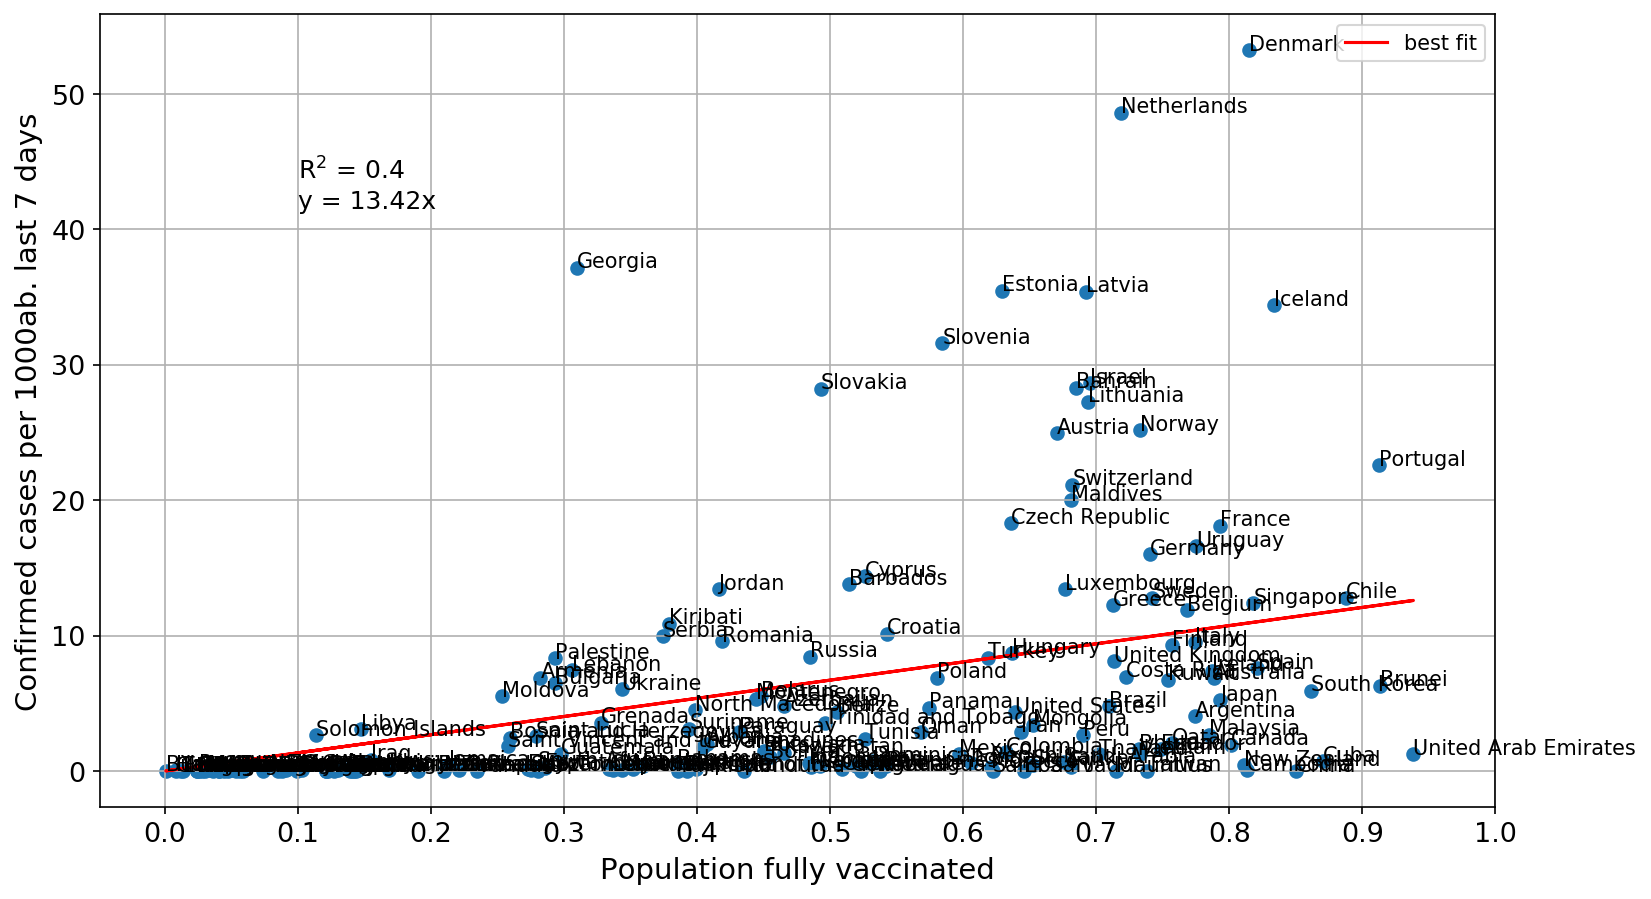

In [18]:
get_scatter_with_fit(df_scatt,
                     yname="confirmed_per_thousand_last_7d", 
                     xtitle="Population fully vaccinated",
                     ytitle="Confirmed cases per 1000ab. last 7 days",
                     savename="confirmed_7d_vs_vax.png",
                     text_xpos=0.1)

                                     OLS Regression Results                                     
Dep. Variable:     deaths_per_thousand_last_7d   R-squared (uncentered):                   0.364
Model:                                     OLS   Adj. R-squared (uncentered):              0.361
Method:                          Least Squares   F-statistic:                              100.9
Date:                         Fri, 11 Feb 2022   Prob (F-statistic):                    4.67e-19
Time:                                 10:46:49   Log-Likelihood:                          436.46
No. Observations:                          177   AIC:                                     -870.9
Df Residuals:                              176   BIC:                                     -867.8
Df Model:                                    1                                                  
Covariance Type:                     nonrobust                                                  
                           coe

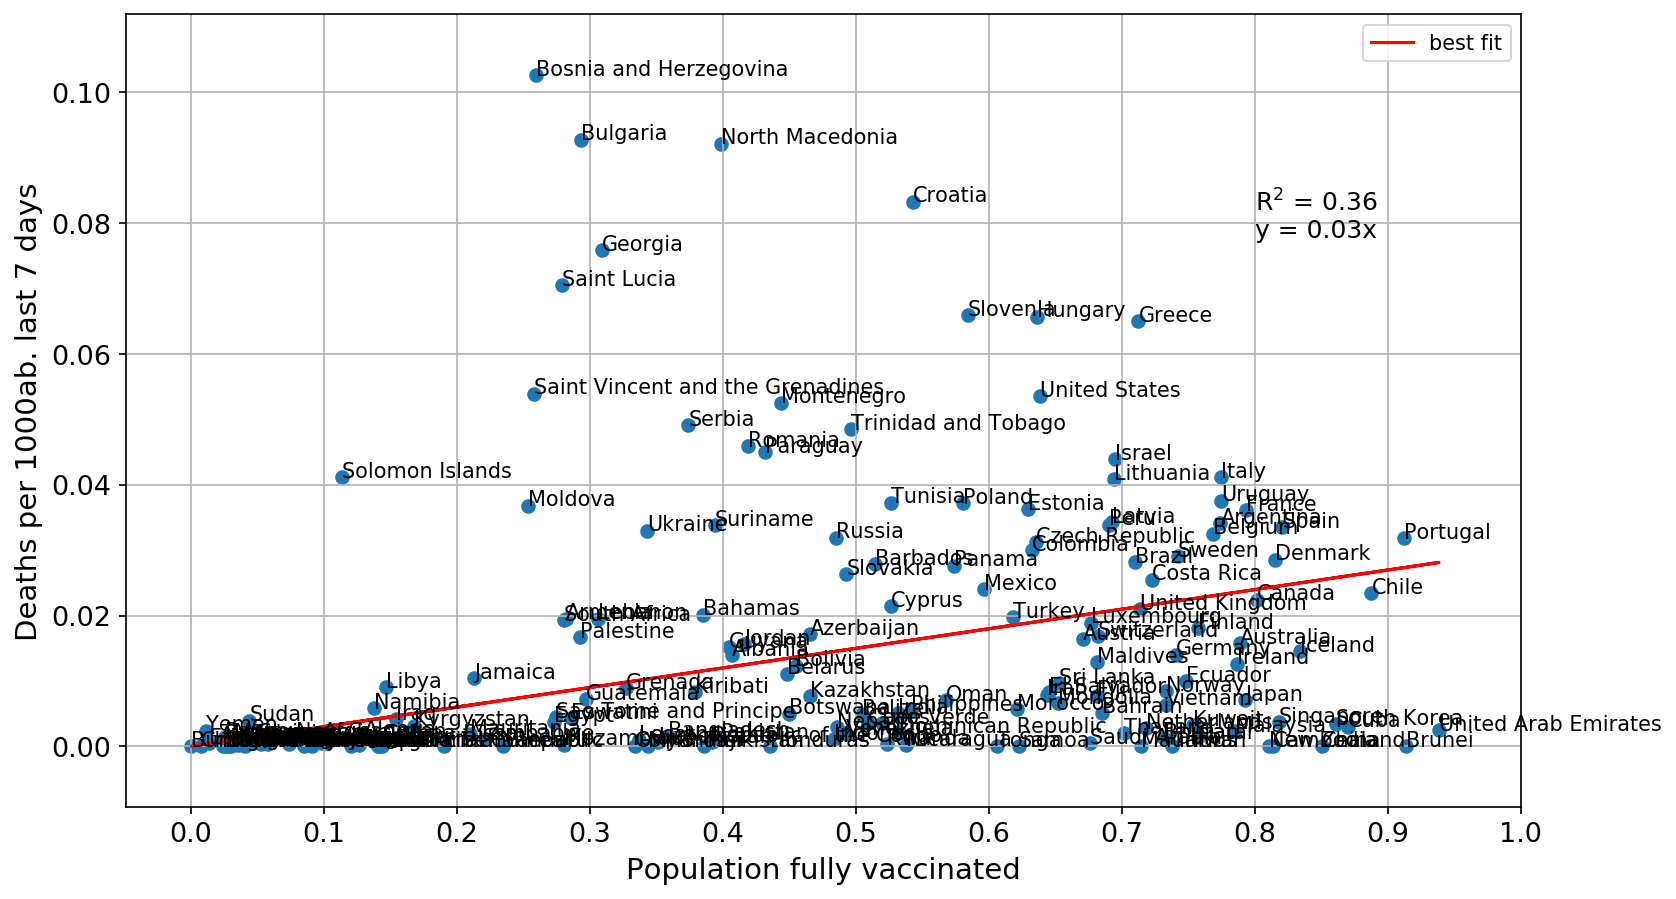

In [19]:
get_scatter_with_fit(df_scatt, 
                     yname="deaths_per_thousand_last_7d", 
                     ytitle="Deaths per 1000ab. last 7 days",
                     xtitle="Population fully vaccinated",
                     savename="deaths_7d_vs_vax.png",
                     text_xpos=0.8)

In [20]:
def create_YoY_plot(df,
                    country: str,
                    varname: str,
                    province: str = None,
                    cumulative: bool = False,
                    verbose = False,
                    per_100k: bool = False,
                    figsize_x: int = 10,
                    figsize_y: int = 5,
                    std_cutoff=20):
    
    df_plot=df[df.Country==country]
    if not province:
        df_plot = df_plot[df_plot.State==""]
    
    df_plot = df_plot.sort_values(by="Date")
    df_plot["Year"] = pd.to_numeric(df_plot["Date"].dt.year)
    df_plot["DayOfYear"] = pd.to_numeric(df_plot["Date"].dt.dayofyear)
    df_plot["DayOfWeek"] = pd.to_numeric(df_plot["Date"].dt.dayofweek)
    df_plot = df_plot.sort_values(by="Date").reset_index().drop(columns=["index"])
    
    mean_deaths = np.mean(df_plot[varname])
    sd_deaths = np.std(df_plot[varname])
    
    df_plot = df_plot[np.abs(df_plot[varname]) <= mean_deaths + std_cutoff*sd_deaths]
    df_plot = df_plot[df_plot[varname] >= 0]
    df_plot[f"{varname}_7d"] = df_plot[varname].rolling(window=7).mean()

    df_years = {}
    years = df_plot["Year"].unique()
    
    today = datetime.strftime(np.max(df_plot["Date"]),"%Y-%m-%d")

    plt.figure(dpi=110, figsize=(figsize_x, figsize_y))
    colors = plt.get_cmap("tab10")
    idx = 0
    for year in sorted(years):
        denominator = 1
        
        dfy = df_plot[df_plot["Year"]==year].sort_values(by="DayOfYear")
        dfy[f"{varname}_cum"] = dfy[varname].cumsum()
        if per_100k:
            denominator = dfy["pop2021"]
        if cumulative: 
            plt.plot(dfy["DayOfYear"], dfy[f"{varname}_cum"]/denominator, label=year, color=colors(idx))
        else:
            plt.plot(dfy["DayOfYear"], dfy[varname]/denominator, alpha=0.3, color=colors(idx))
            plt.plot(dfy["DayOfYear"], dfy[f"{varname}_7d"]/denominator, label=year, color=colors(idx))
        idx += 1
        df_years[year]= dfy
        
    plt.grid()
    plt.xlabel("day of the year", fontsize=12)
    ylabel_txt = f"{varname}"
    filename = f"./plots/yoy_{country}_{varname}"
    if cumulative:
        ylabel_txt = f"cumulative {ylabel_txt}"
        filename += "_cumulative"
    plt.ylabel(ylabel_txt.replace("_"," "), fontsize=12)
    plt_title = f"{country}  -  Covid19 {varname}"
    if cumulative:
        plt_title += " total"
    if province:
        plt_title += f", {province}"
        filename += f"_{province}"
    filename += ".png"
    plt_title += f"  -  {today}"
    plt.title(plt_title.replace("_"," "), fontsize=14)
    plt.legend()
    plt.savefig(filename, bbox_inches="tight")
    return df_years

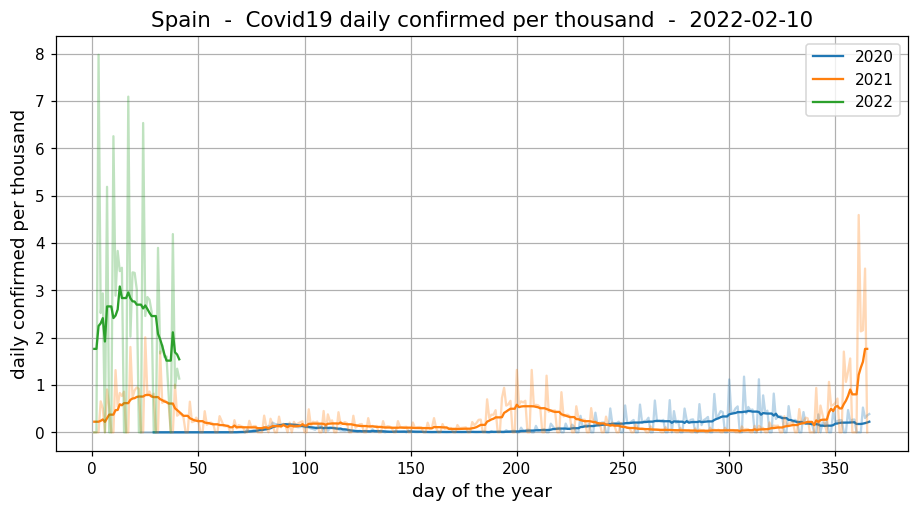

In [21]:
_ = create_YoY_plot(df, 
                    country="Spain", 
                    varname="daily_confirmed_per_thousand", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

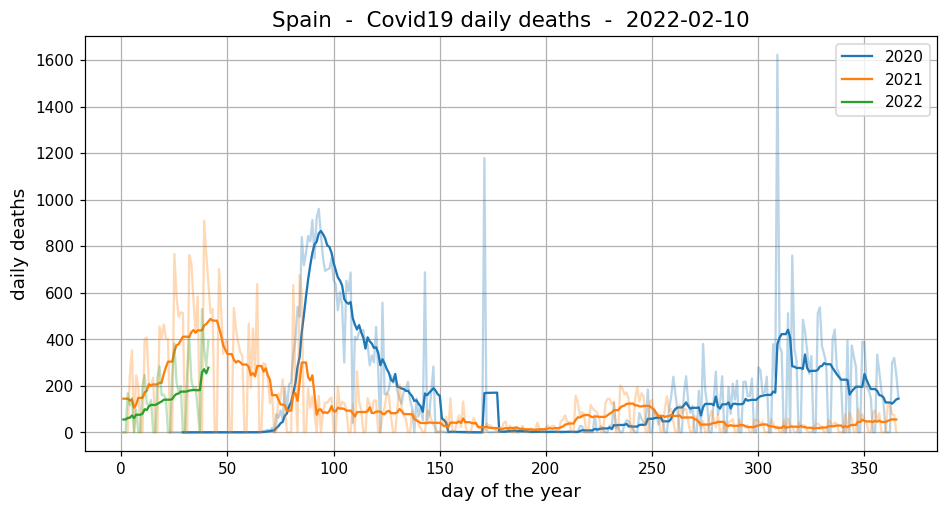

In [22]:
_ = create_YoY_plot(df, 
                    country="Spain", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

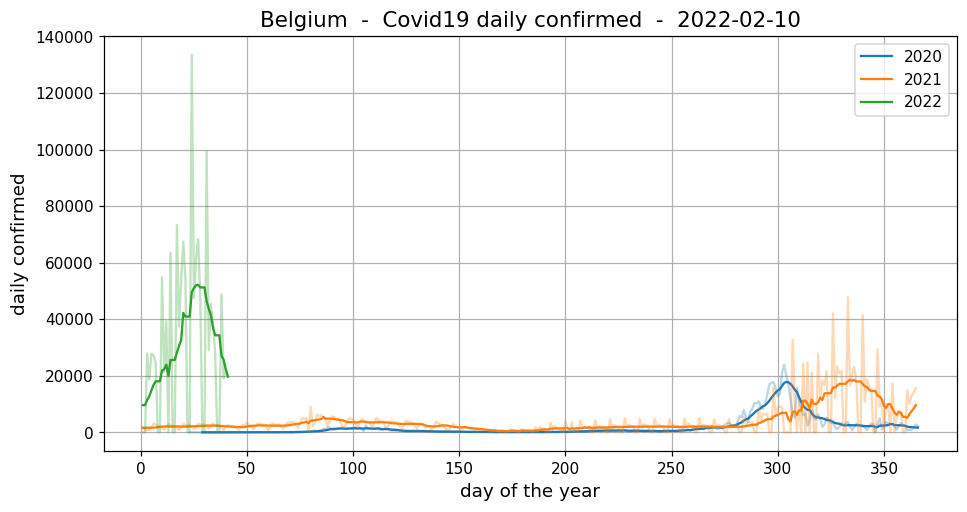

In [23]:
_ = create_YoY_plot(df, 
                    country="Belgium", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

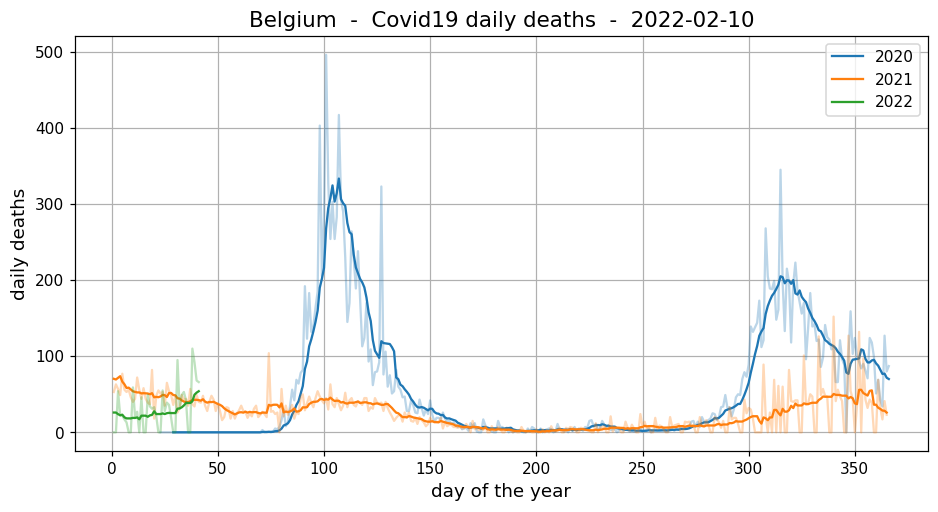

In [24]:
_ = create_YoY_plot(df, 
                    country="Belgium", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

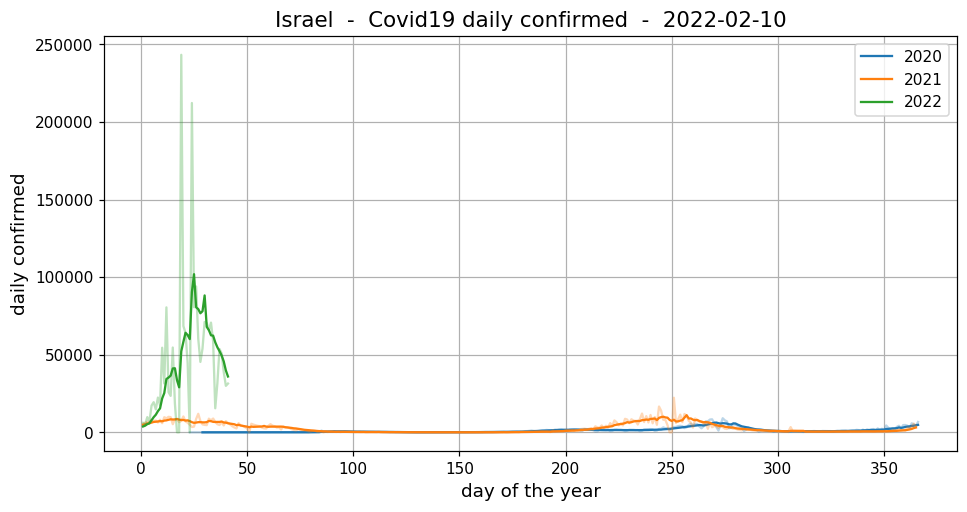

In [25]:
_ = create_YoY_plot(df, 
                    country="Israel", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

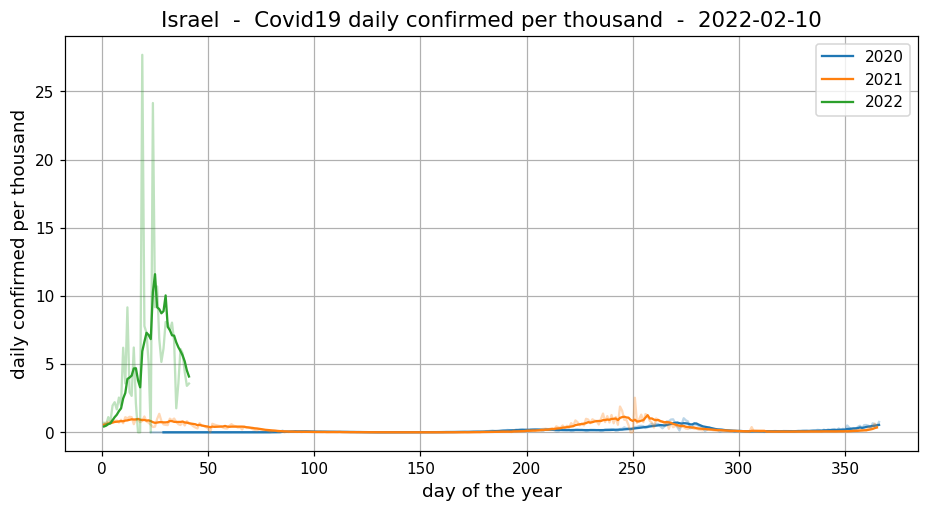

In [26]:
_ = create_YoY_plot(df, 
                    country="Israel", 
                    varname="daily_confirmed_per_thousand", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

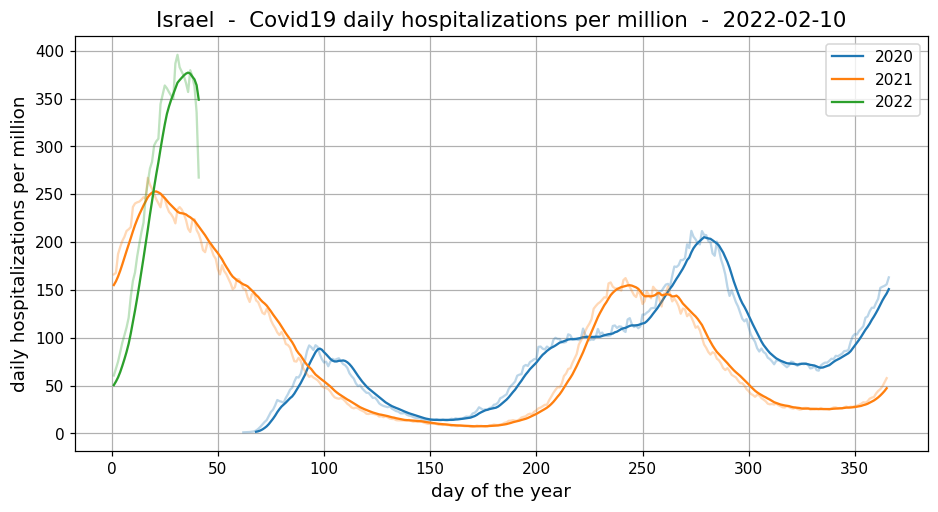

In [27]:
_ = create_YoY_plot(df, 
                    country="Israel", 
                    varname="daily_hospitalizations_per_million", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

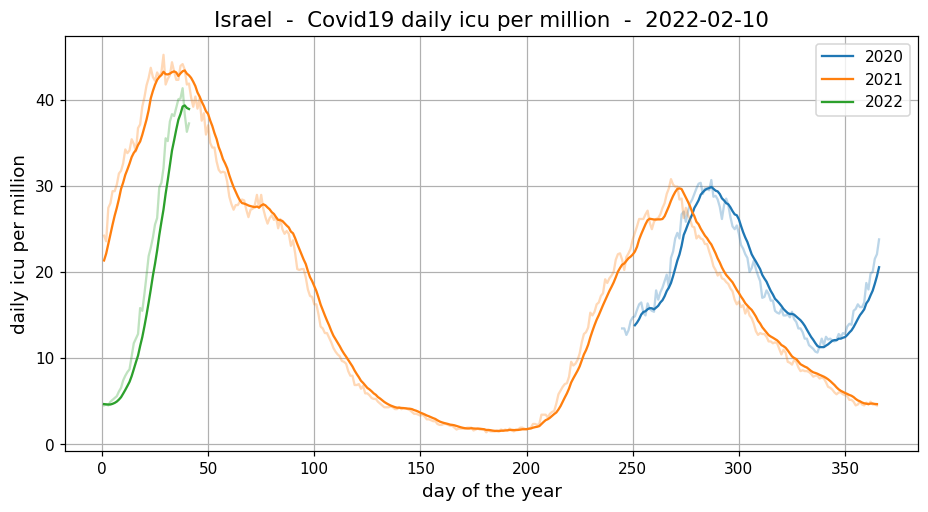

In [28]:
_ = create_YoY_plot(df, 
                    country="Israel", 
                    varname="daily_icu_per_million", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

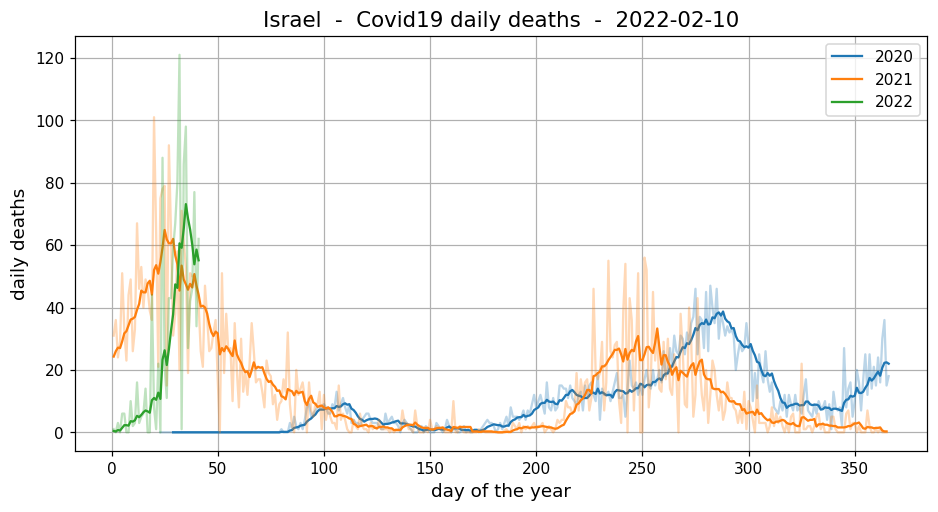

In [29]:
_ = create_YoY_plot(df, 
                    country="Israel", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

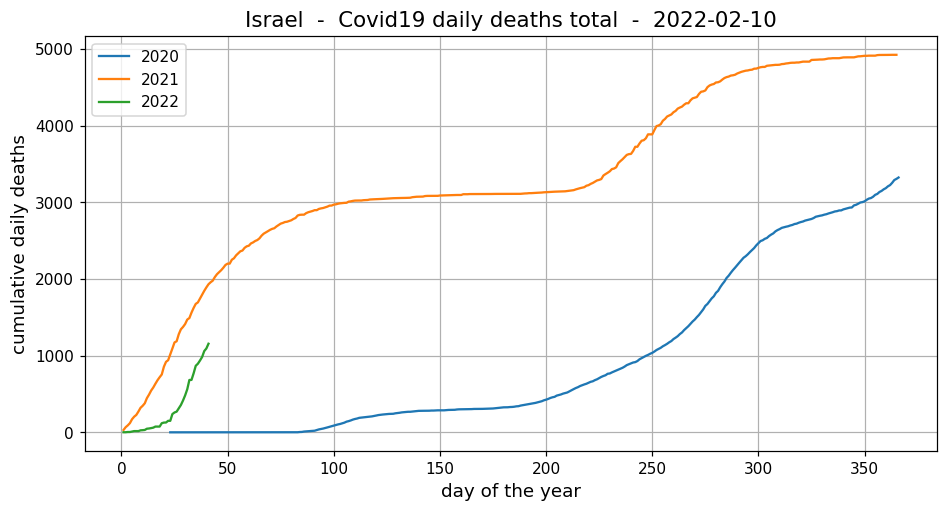

In [31]:
_ = create_YoY_plot(df, 
                    country="Israel", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=True,
                    std_cutoff=100)

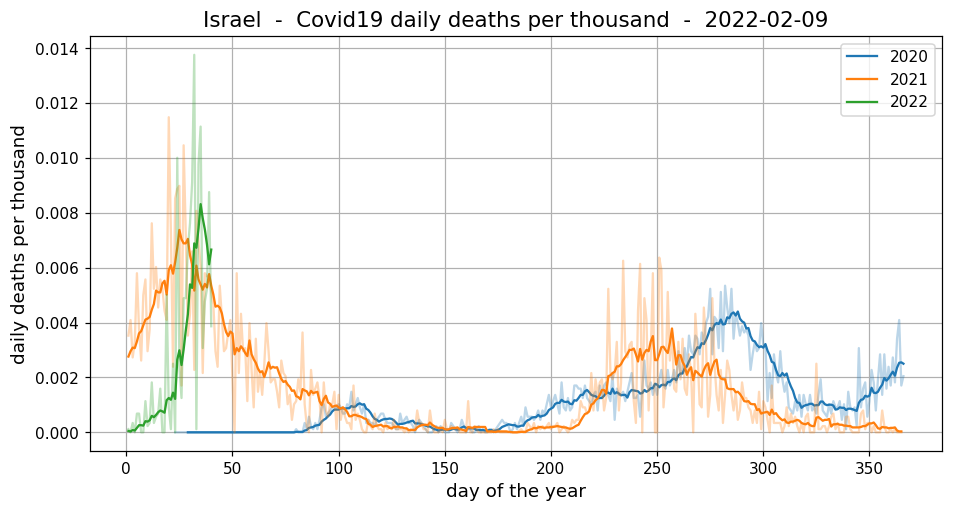

In [44]:
_ = create_YoY_plot(df, 
                    country="Israel", 
                    varname="daily_deaths_per_thousand", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

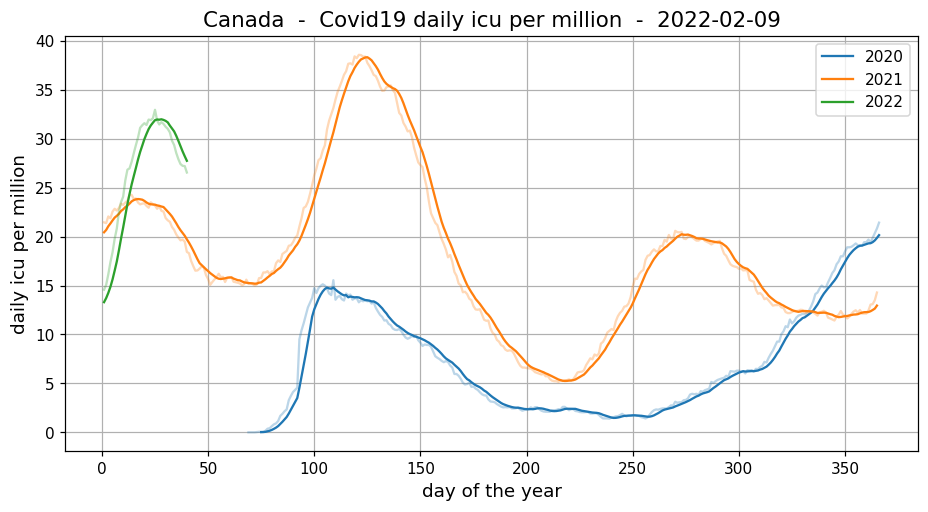

In [45]:
_ = create_YoY_plot(df, 
                    country="Canada", 
                    varname="daily_icu_per_million", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

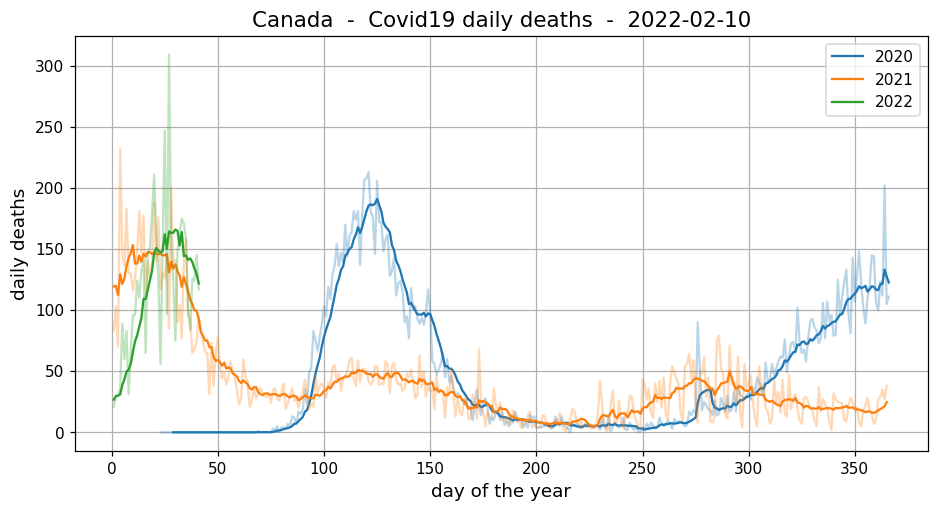

In [32]:
_ = create_YoY_plot(df, 
                    country="Canada", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

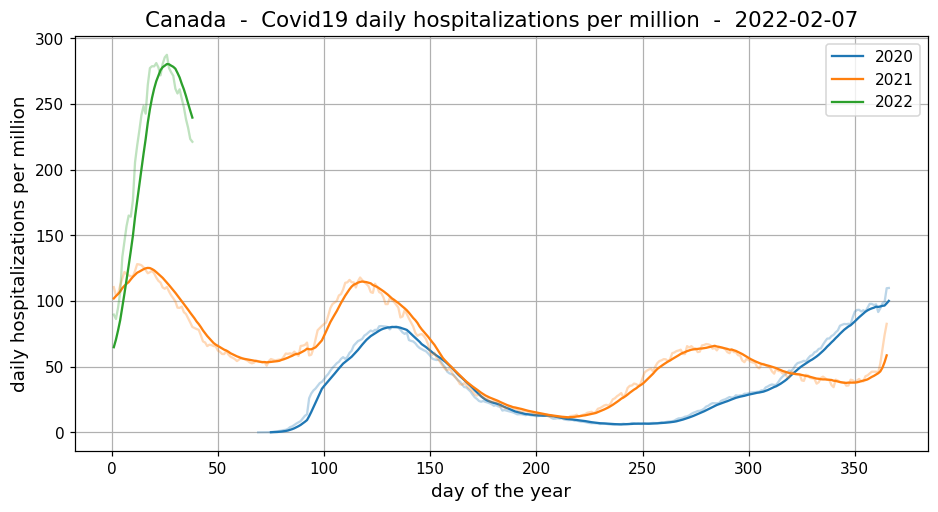

In [31]:
_ = create_YoY_plot(df, 
                    country="Canada", 
                    varname="daily_hospitalizations_per_million", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

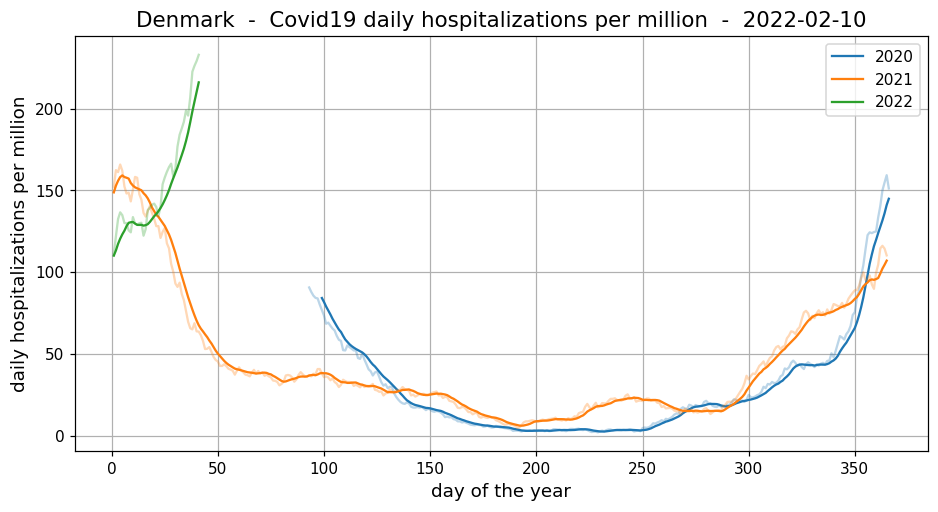

In [33]:
_ = create_YoY_plot(df, 
                    country="Denmark", 
                    varname="daily_hospitalizations_per_million", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

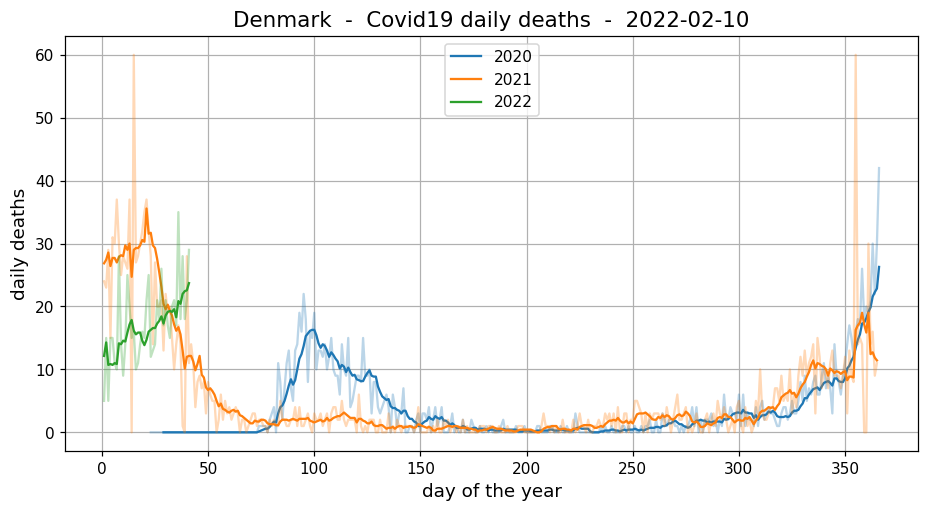

In [34]:
_ = create_YoY_plot(df, 
                    country="Denmark", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

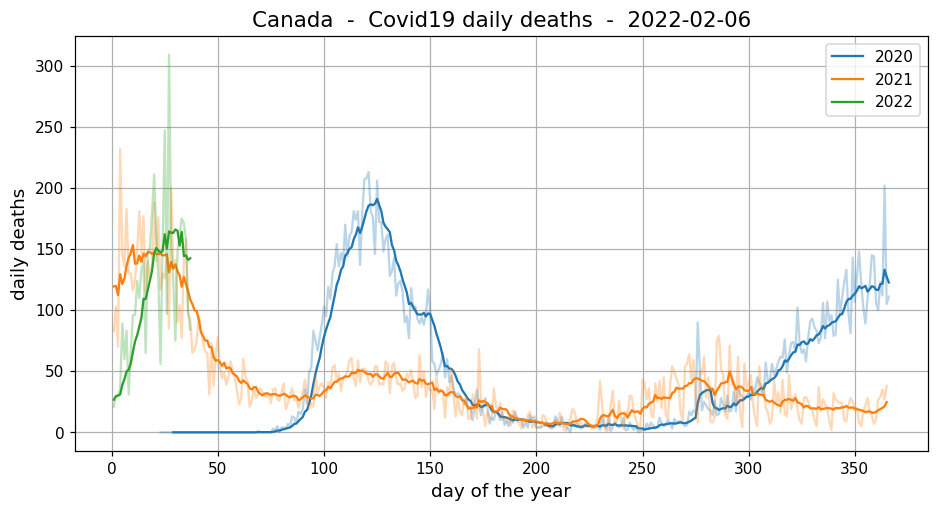

In [36]:
_ = create_YoY_plot(df, 
                    country="Canada", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

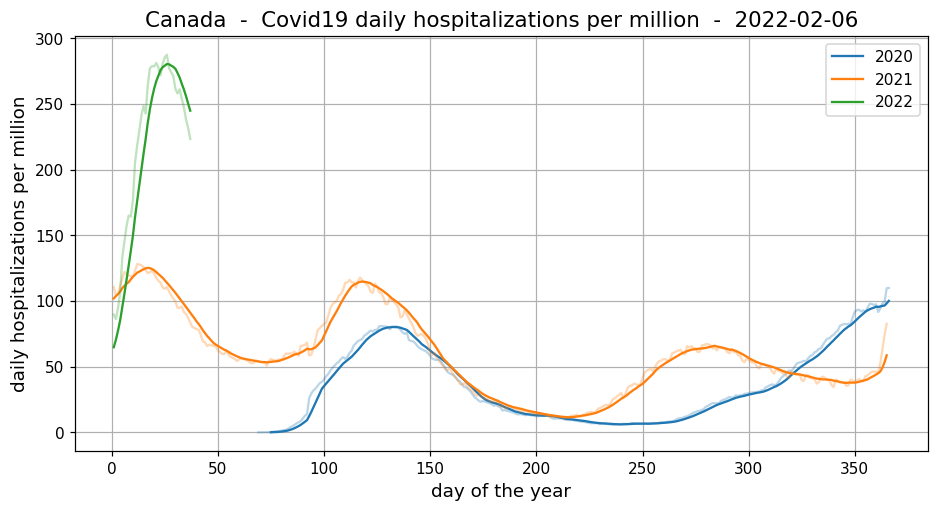

In [37]:
_ = create_YoY_plot(df, 
                    country="Canada", 
                    varname="daily_hospitalizations_per_million", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

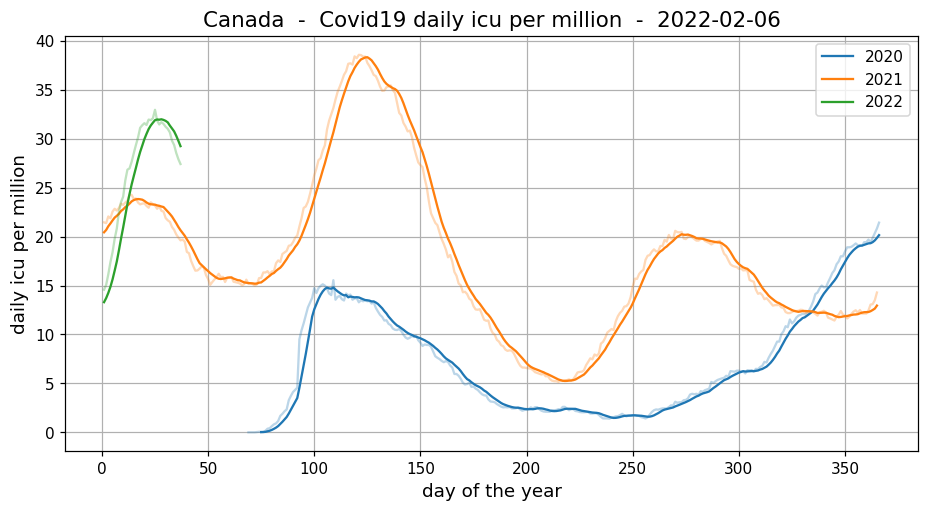

In [38]:
_ = create_YoY_plot(df, 
                    country="Canada", 
                    varname="daily_icu_per_million", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

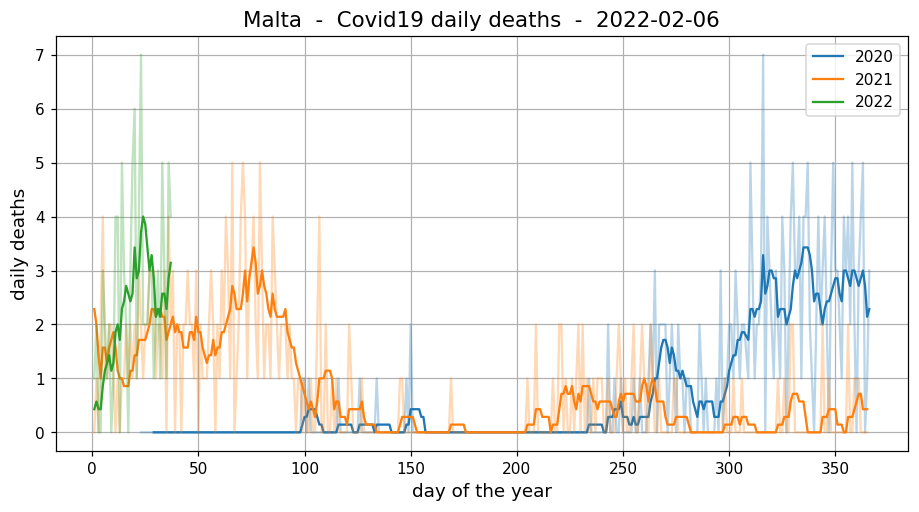

In [40]:
_ = create_YoY_plot(df, 
                    country="Malta", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

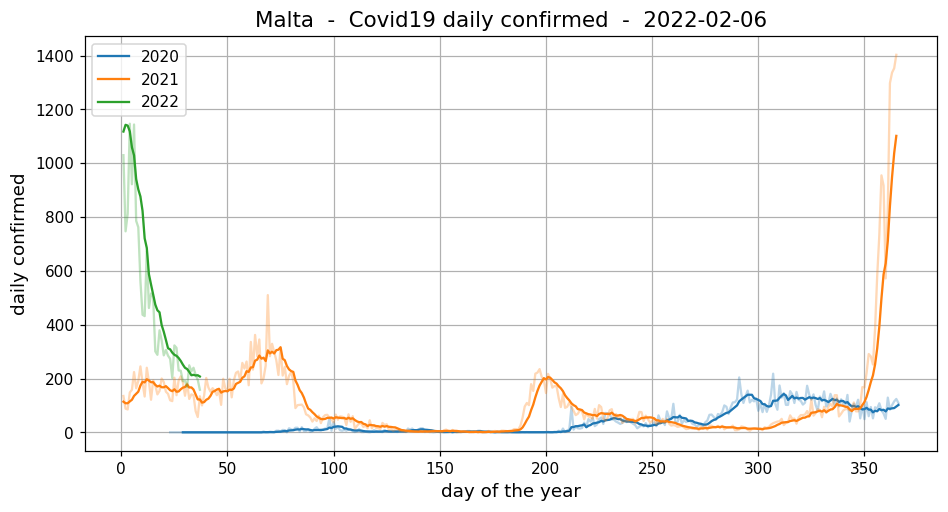

In [41]:
_ = create_YoY_plot(df, 
                    country="Malta", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

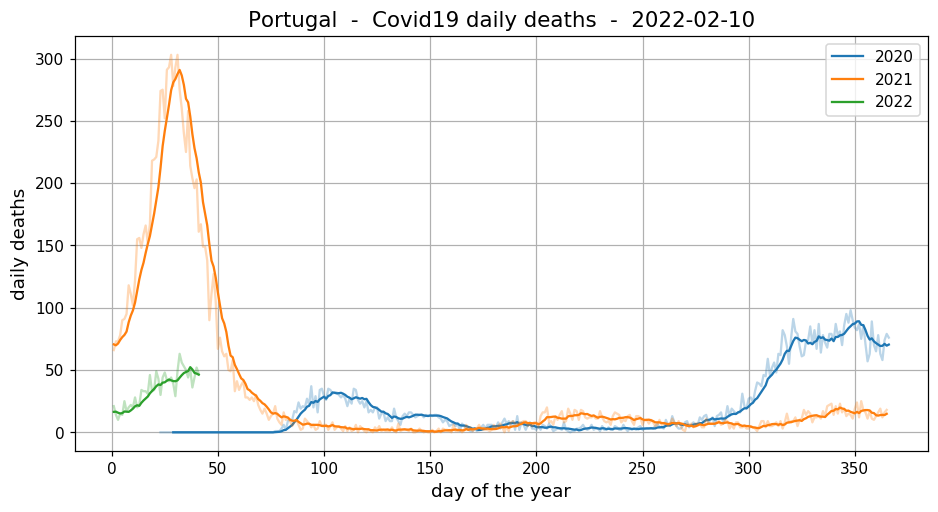

In [35]:
_ = create_YoY_plot(df, 
                    country="Portugal", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

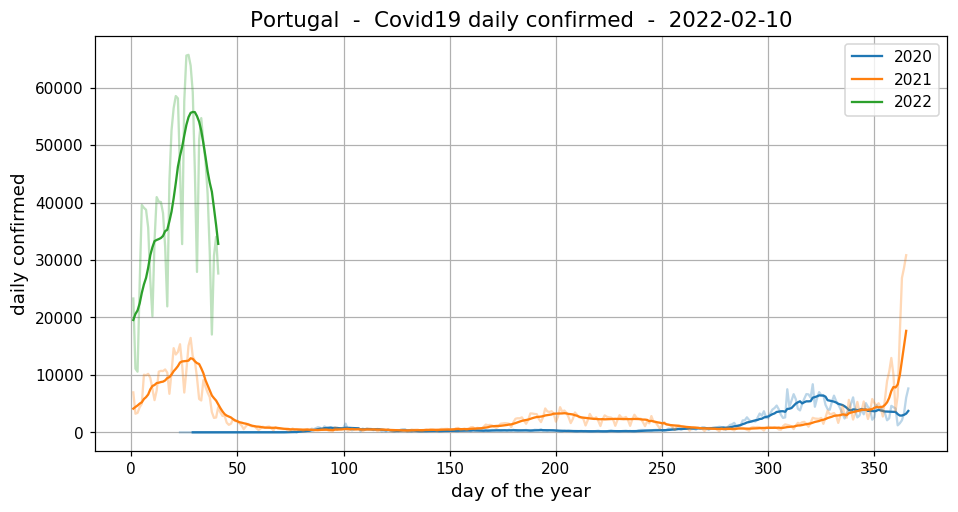

In [36]:
_ = create_YoY_plot(df, 
                    country="Portugal", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

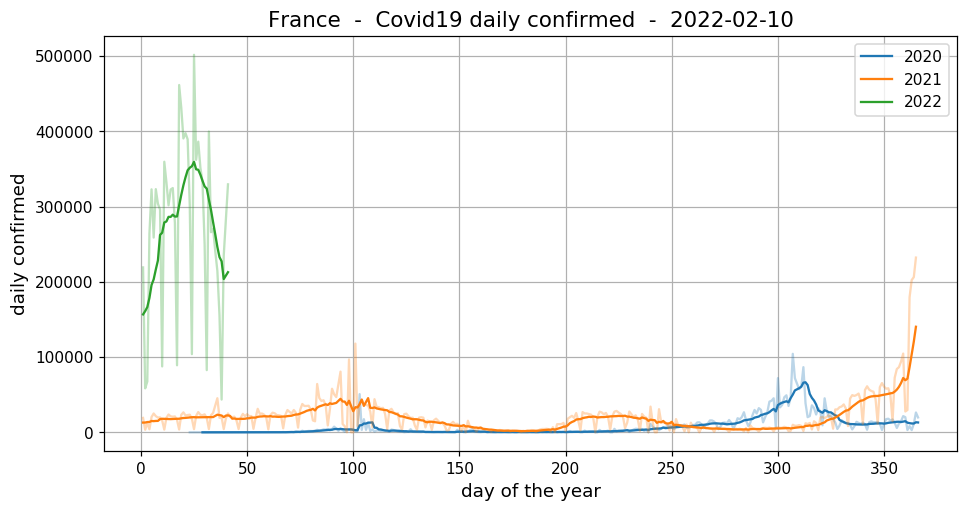

In [37]:
df_france = create_YoY_plot(df, 
                    country="France", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

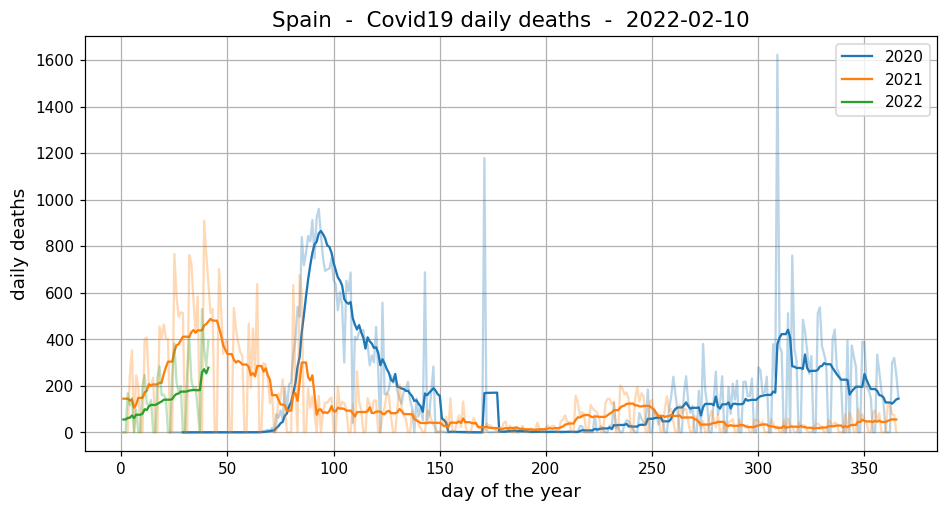

In [41]:
df_france = create_YoY_plot(df, 
                    country="Spain", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

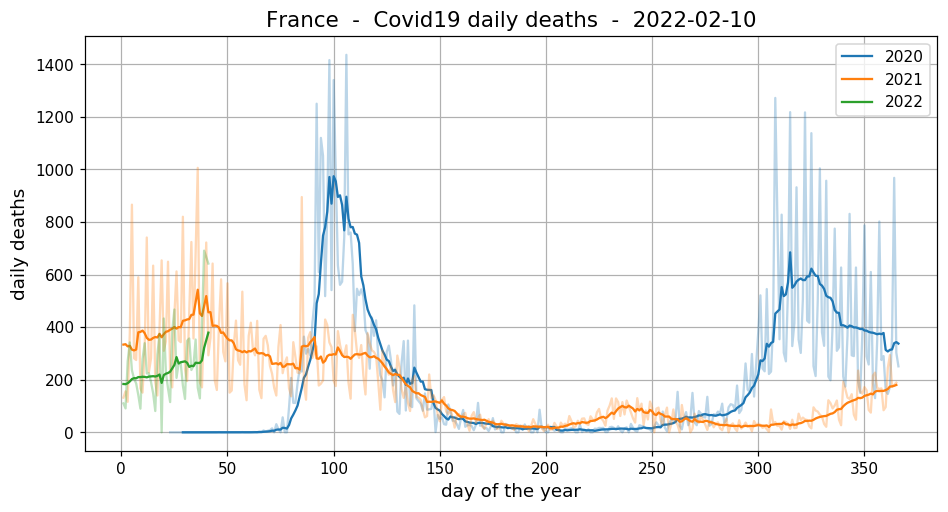

In [38]:
df_france = create_YoY_plot(df, 
                    country="France", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

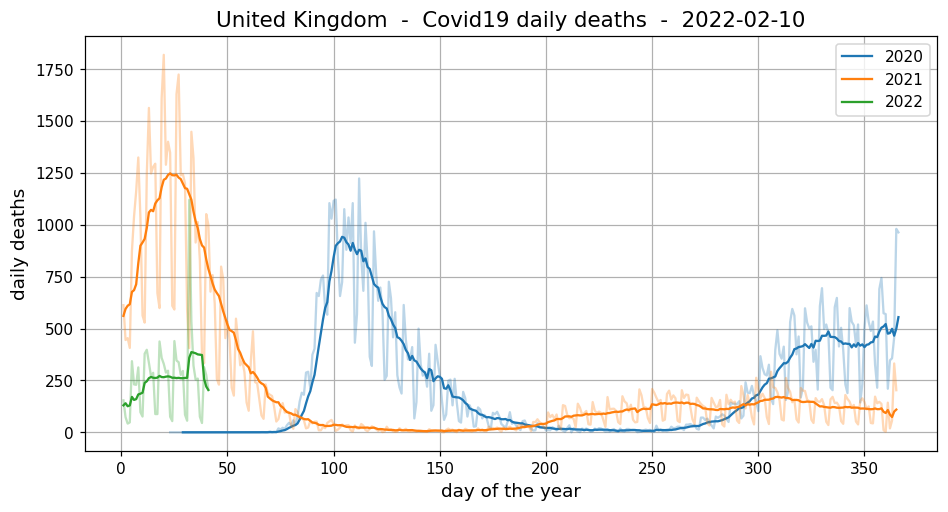

In [39]:
 _ = create_YoY_plot(df, 
                    country="United Kingdom", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

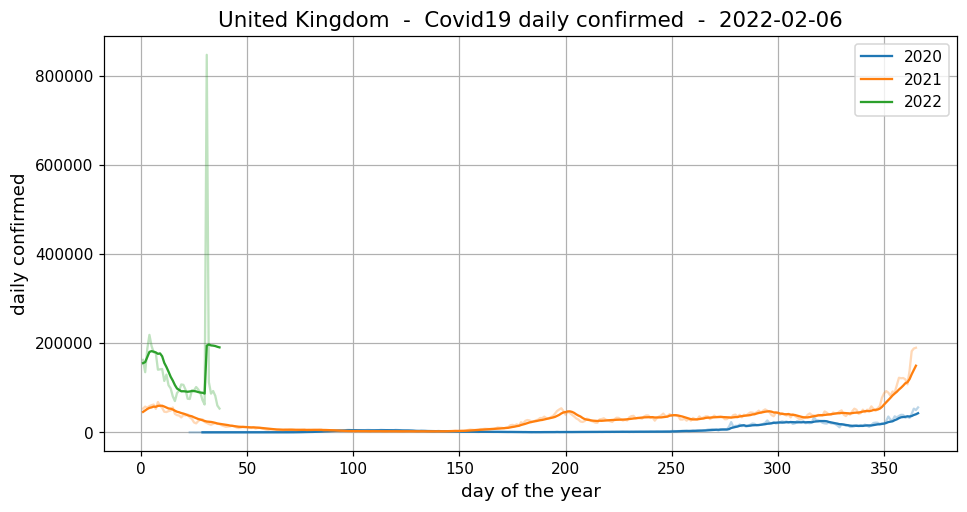

In [47]:
 _ = create_YoY_plot(df, 
                    country="United Kingdom", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

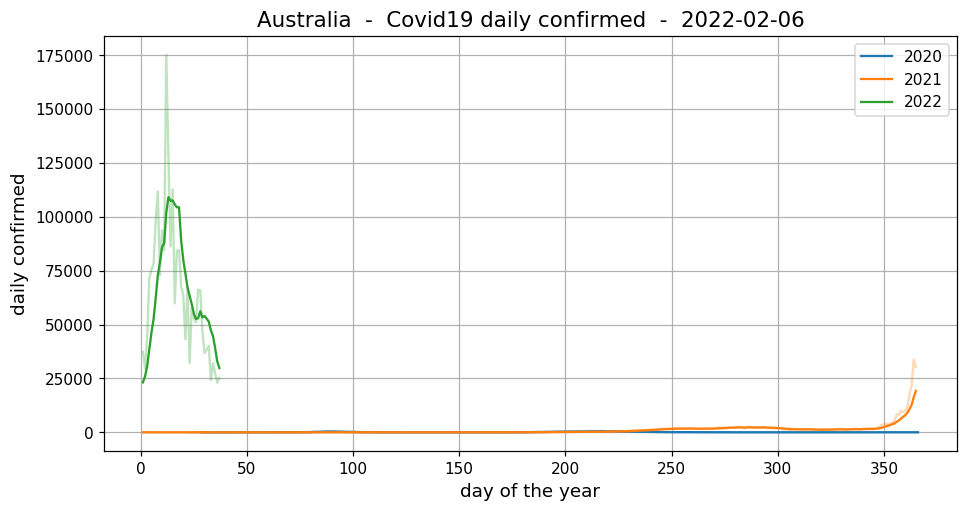

In [48]:
_ = create_YoY_plot(df, 
                    country="Australia", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

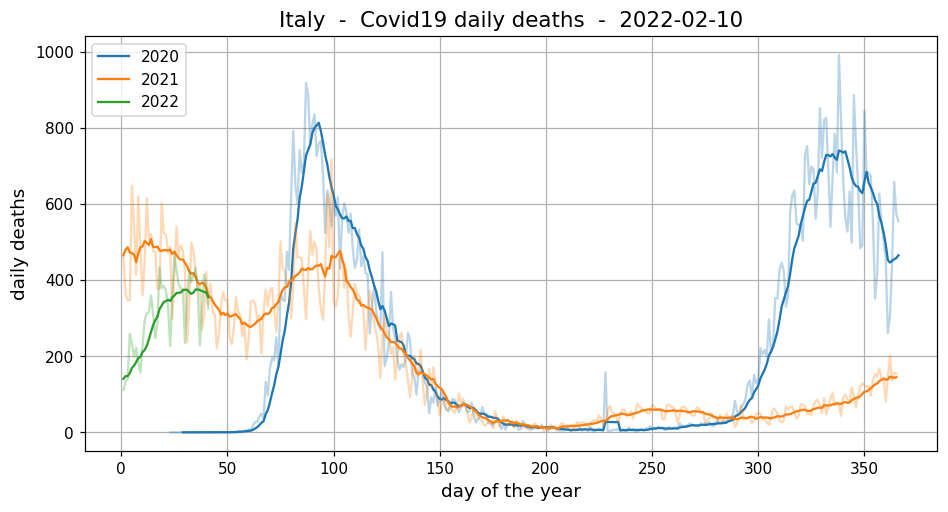

In [40]:
 _ = create_YoY_plot(df, 
                    country="Italy", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

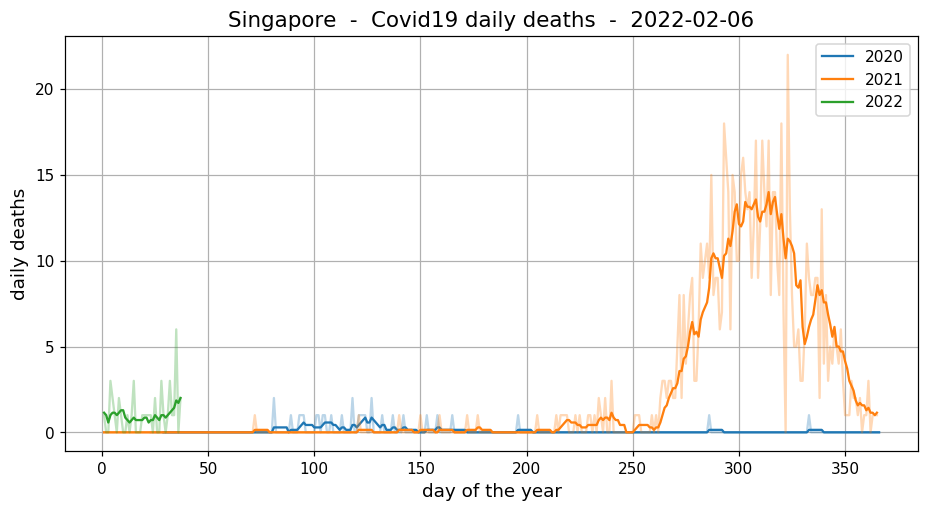

In [49]:
 _ = create_YoY_plot(df, 
                    country="Singapore", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

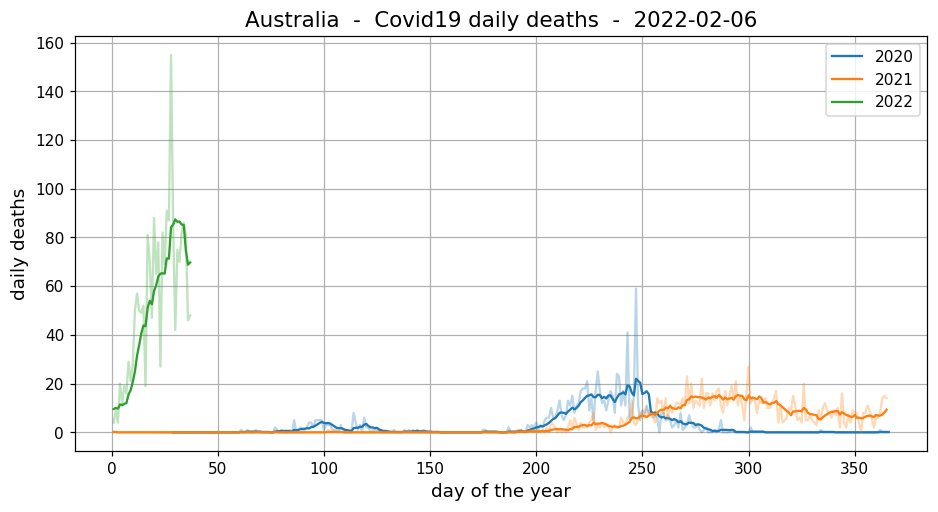

In [50]:
_ = create_YoY_plot(df, 
                    country="Australia", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

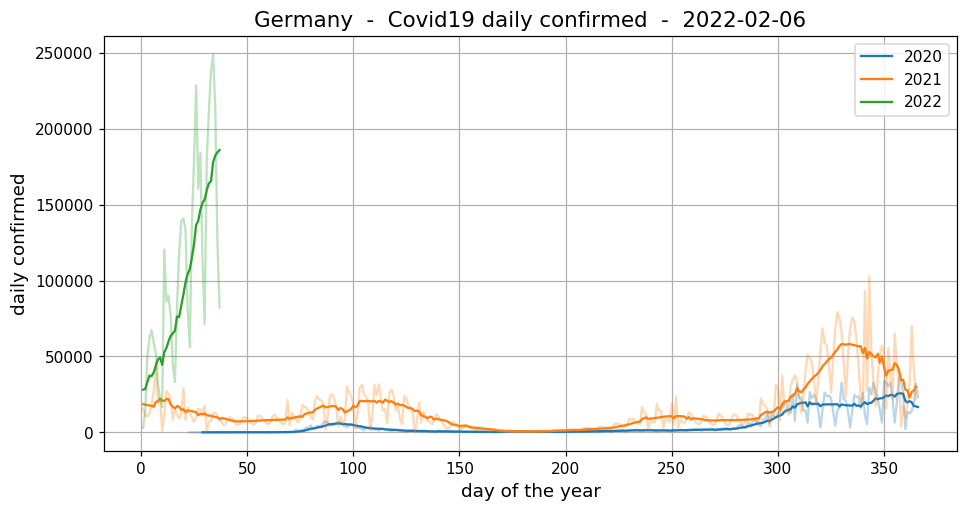

In [51]:
_ = create_YoY_plot(df, 
                    country="Germany", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

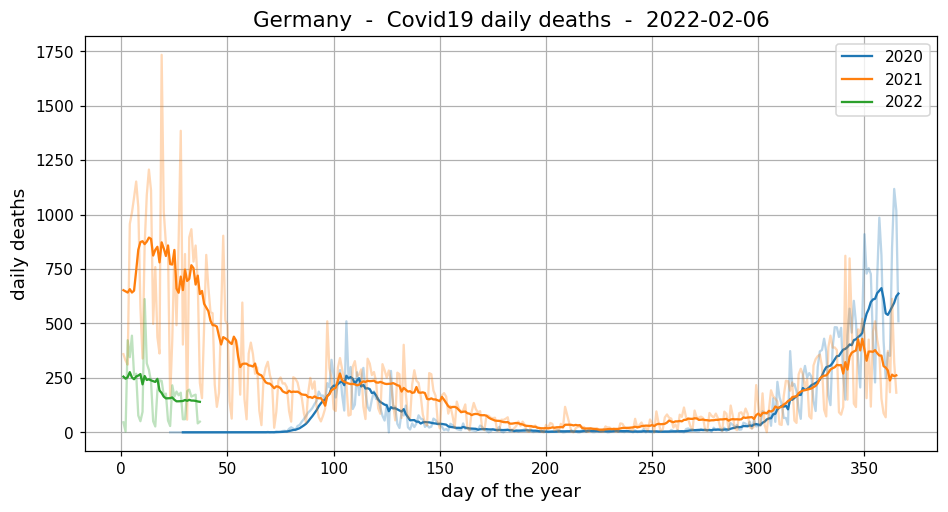

In [52]:
df_germany = create_YoY_plot(df, 
                    country="Germany", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

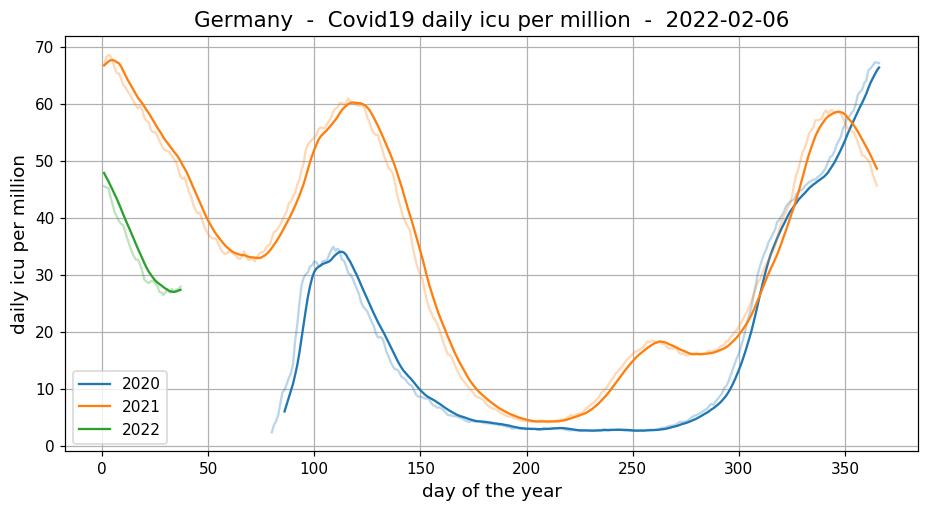

In [53]:
df_germany = create_YoY_plot(df, 
                    country="Germany", 
                    varname="daily_icu_per_million", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

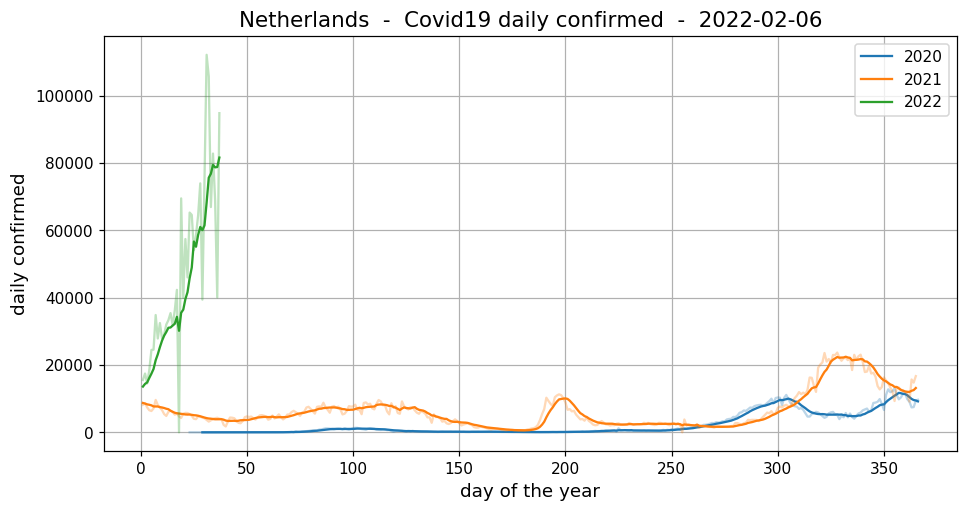

In [54]:
_ = create_YoY_plot(df, 
                    country="Netherlands", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

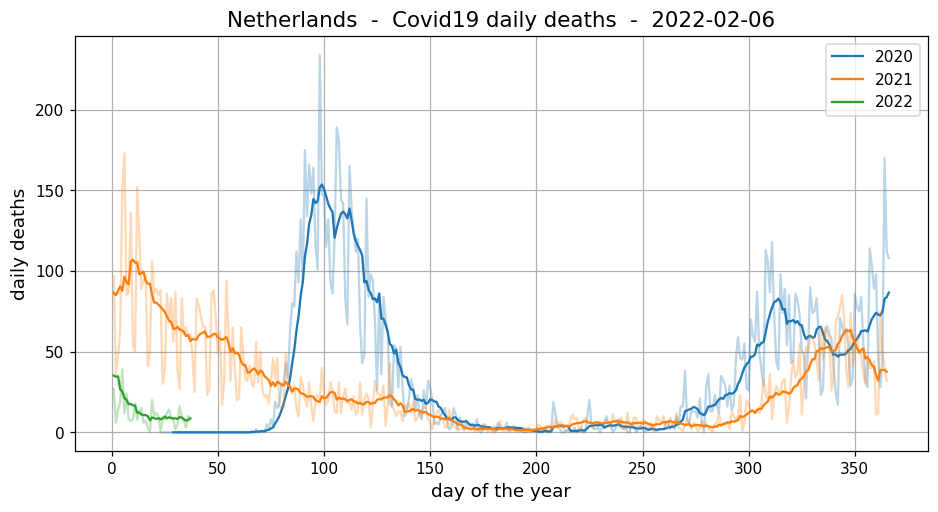

In [55]:
_ = create_YoY_plot(df, 
                    country="Netherlands", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

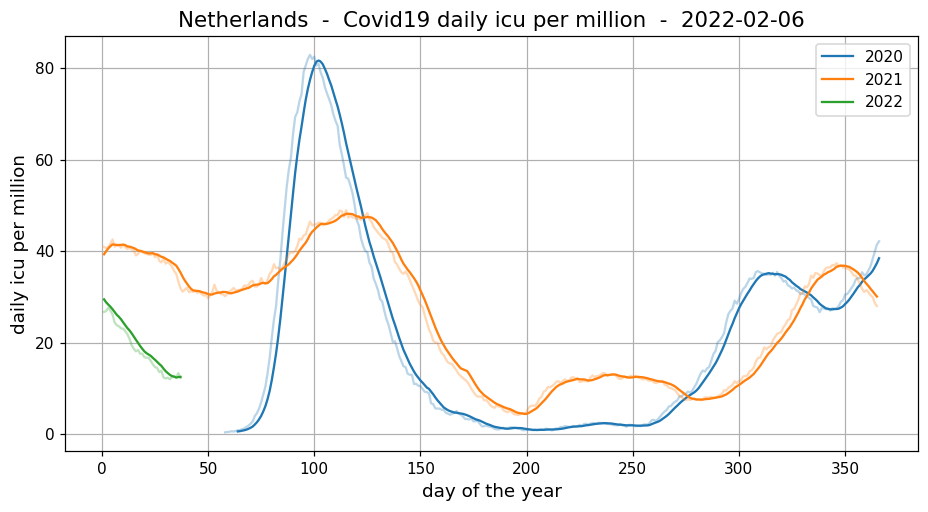

In [56]:
_ = create_YoY_plot(df, 
                    country="Netherlands", 
                    varname="daily_icu_per_million", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

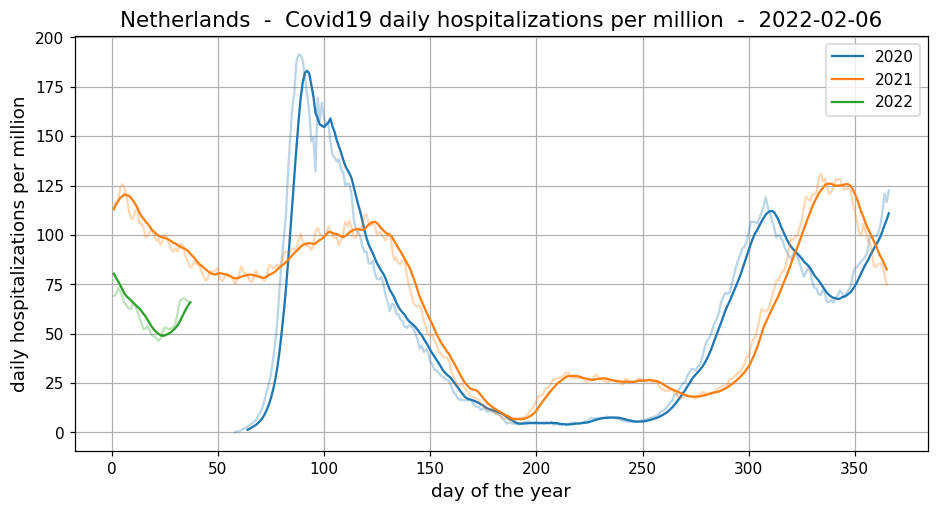

In [57]:
_ = create_YoY_plot(df, 
                    country="Netherlands", 
                    varname="daily_hospitalizations_per_million", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=100)

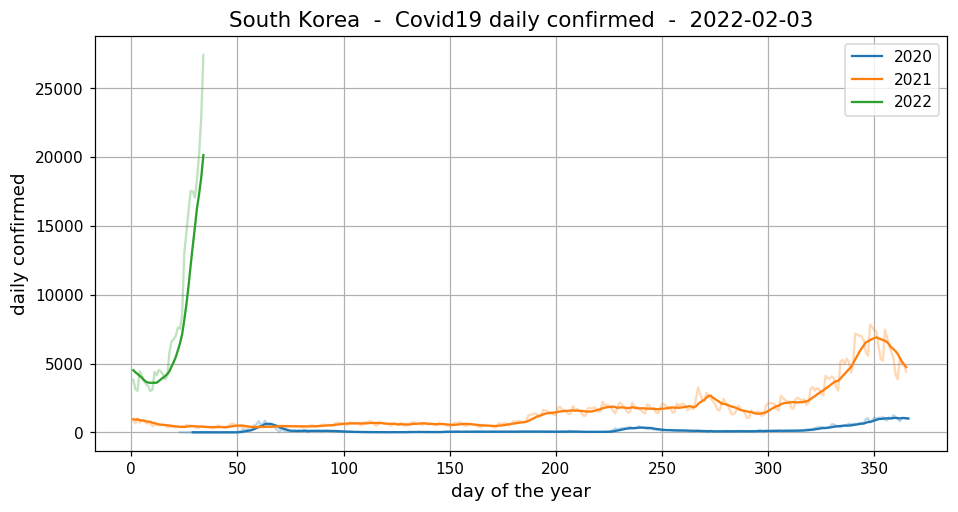

In [48]:
_ = create_YoY_plot(df, 
                    country="South Korea", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

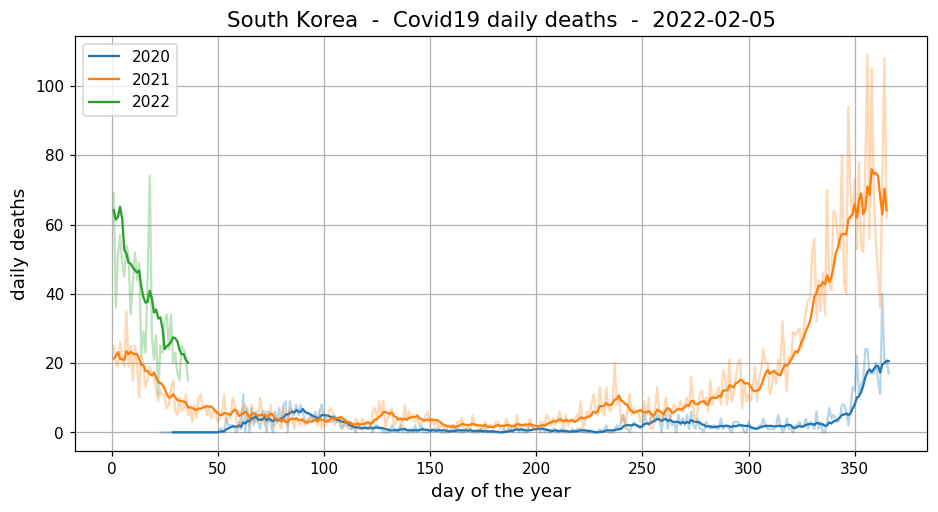

In [49]:
_ = create_YoY_plot(df, 
                    country="South Korea", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

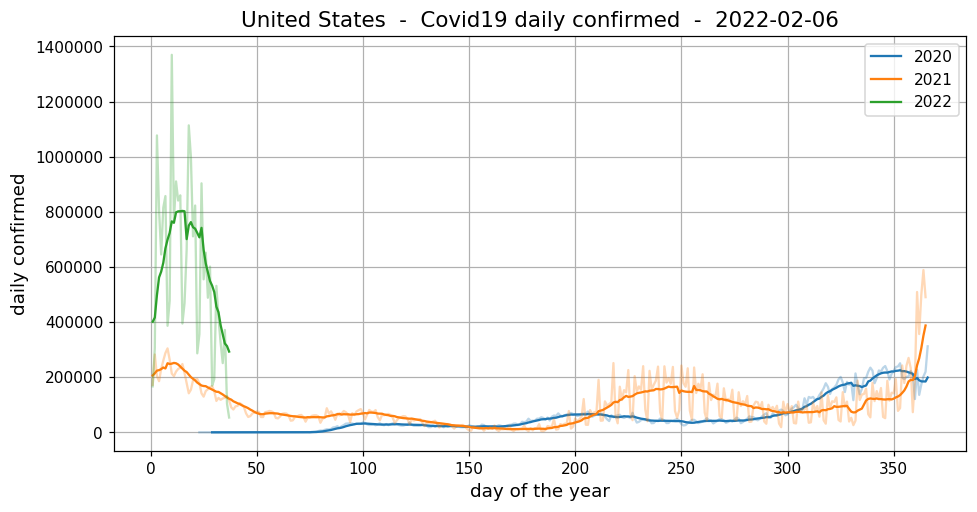

In [58]:
_ = create_YoY_plot(df, 
                    country="United States", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

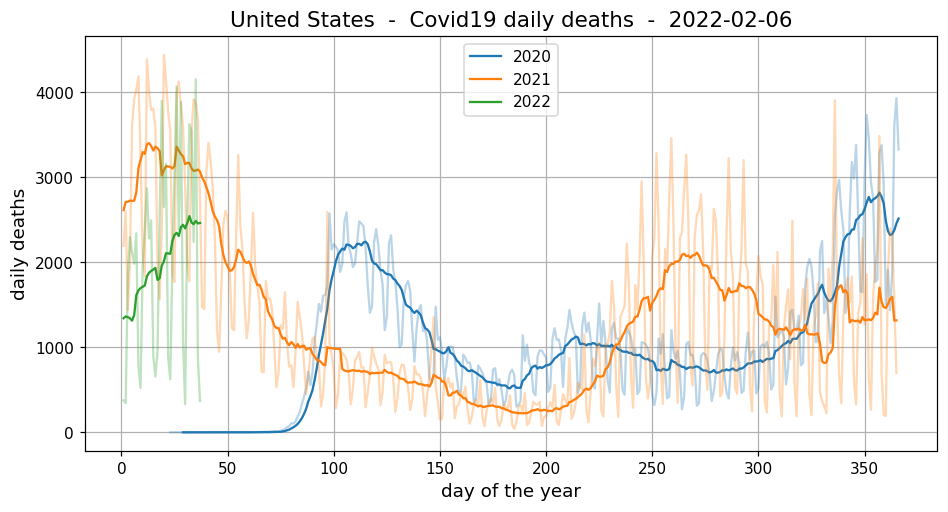

In [59]:
df_us = create_YoY_plot(df, 
                    country="United States", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

In [60]:
pd.concat([df_us[2020],df_us[2021],df_us[2022]]).sort_values(by="daily_deaths", ascending=False)[["Date","daily_deaths"]]

Date  daily_deaths
364 2021-01-20        4442.0
356 2021-01-12        4389.0
352 2021-01-08        4189.0
744 2022-02-04        4154.0
365 2021-01-21        4137.0
..         ...           ...
26  2020-02-17           0.0
24  2020-02-15           0.0
23  2020-02-14           0.0
22  2020-02-13           0.0
1   2020-01-23           0.0

[746 rows x 2 columns]

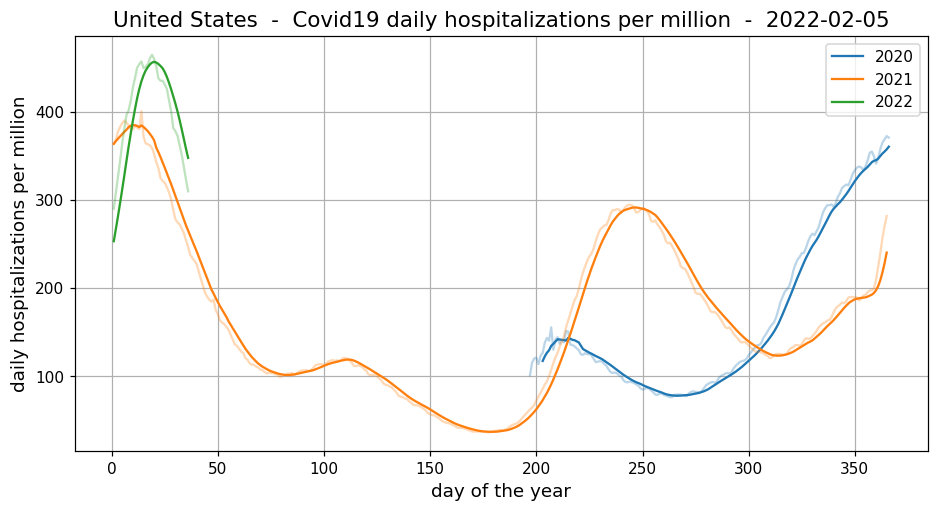

In [62]:
_ = create_YoY_plot(df, 
                    country="United States", 
                    varname="daily_hospitalizations_per_million", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

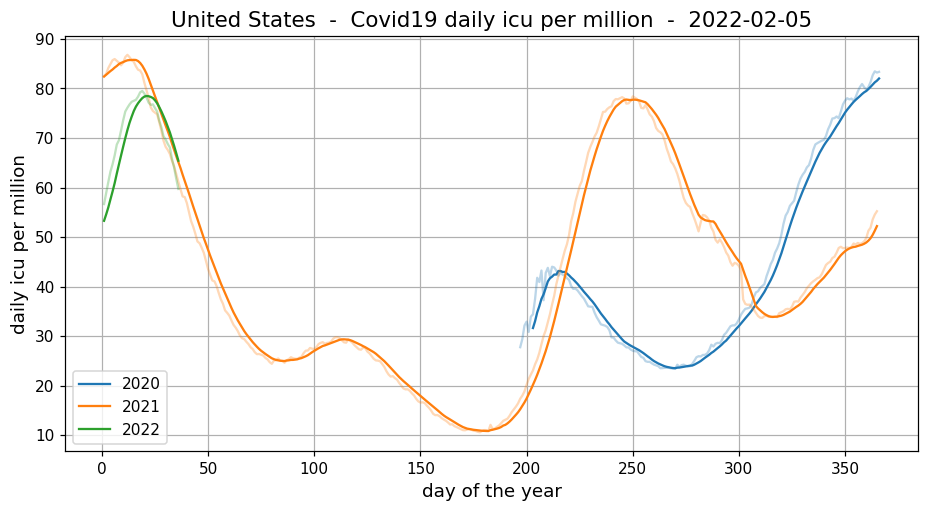

In [63]:
_ = create_YoY_plot(df, 
                    country="United States", 
                    varname="daily_icu_per_million", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

In [ ]:
_ = create_YoY_plot(df, 
                    country="Brazil", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

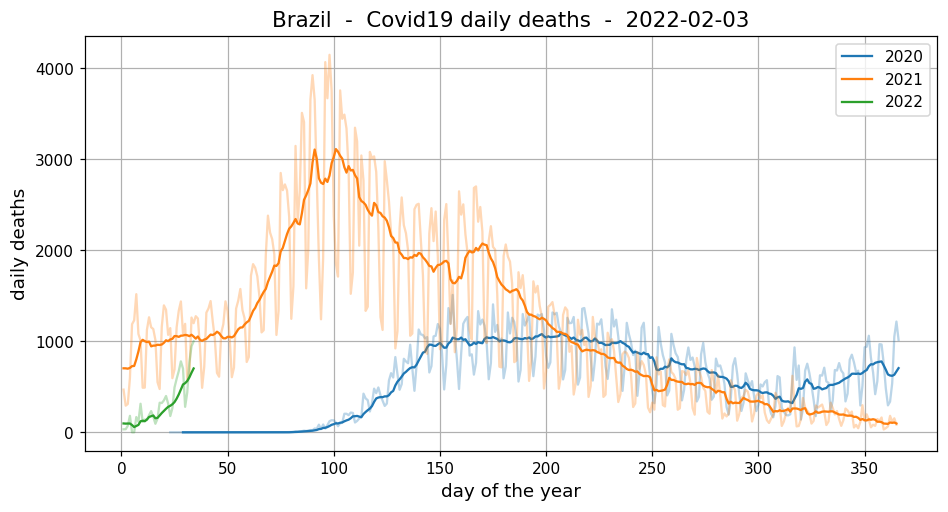

In [60]:
_ = create_YoY_plot(df, 
                    country="Brazil", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

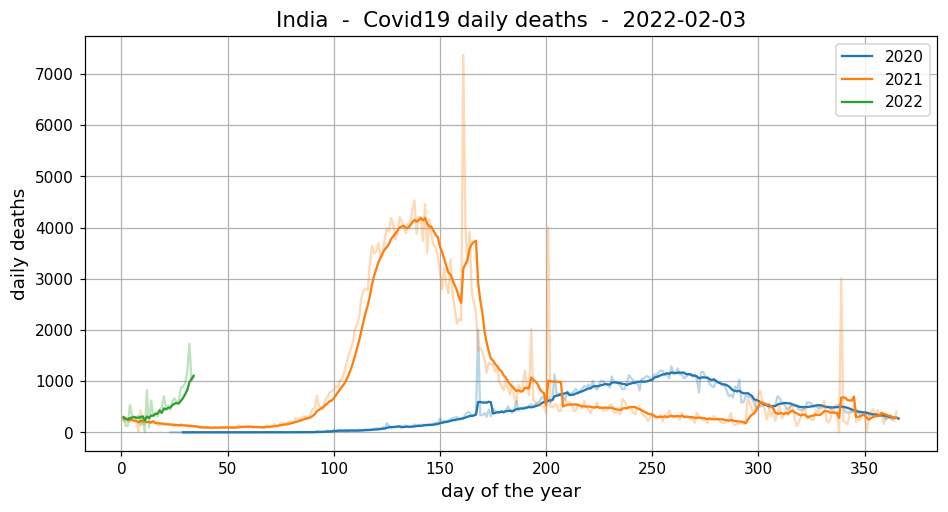

In [61]:
_ = create_YoY_plot(df, 
                    country="India", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

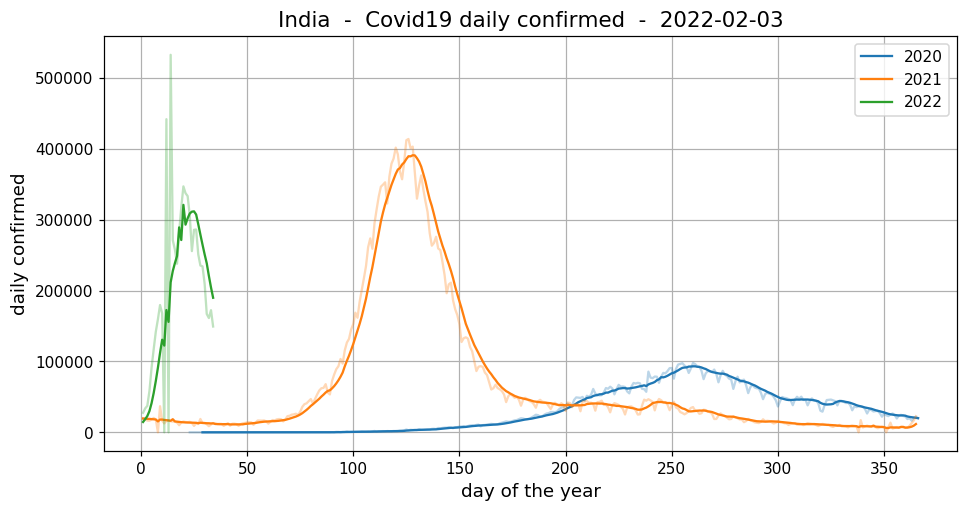

In [62]:
_ = create_YoY_plot(df, 
                    country="India", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

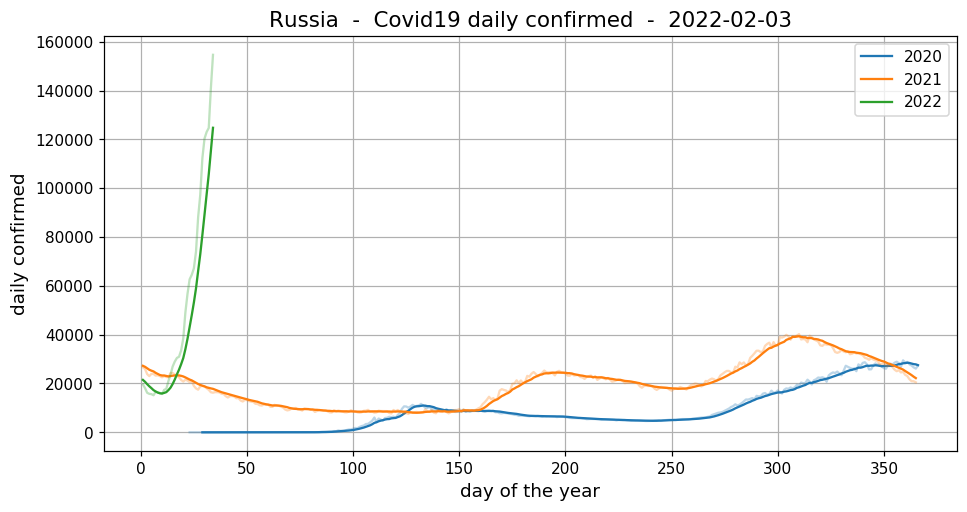

In [63]:
_ = create_YoY_plot(df, 
                    country="Russia", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

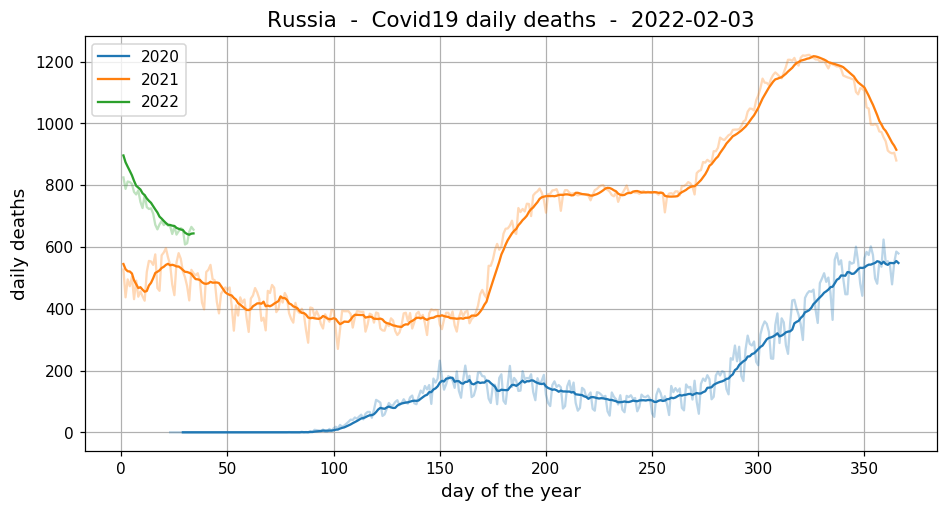

In [64]:
_ = create_YoY_plot(df, 
                    country="Russia", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

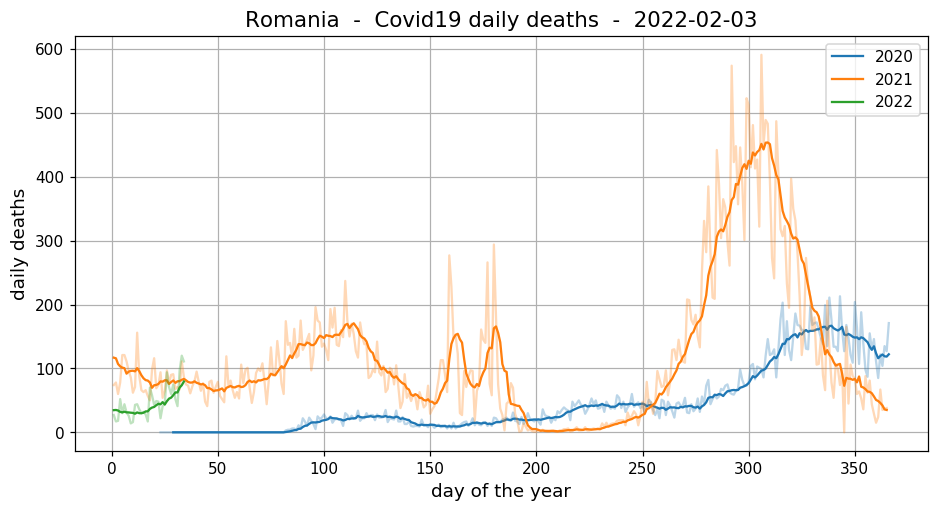

In [65]:
_ = create_YoY_plot(df, 
                    country="Romania", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

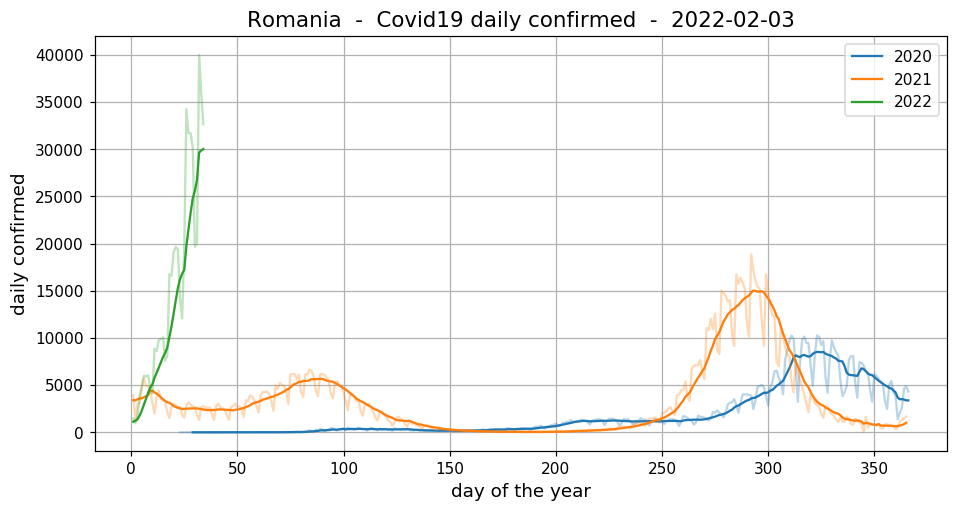

In [66]:
_ = create_YoY_plot(df, 
                    country="Romania", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

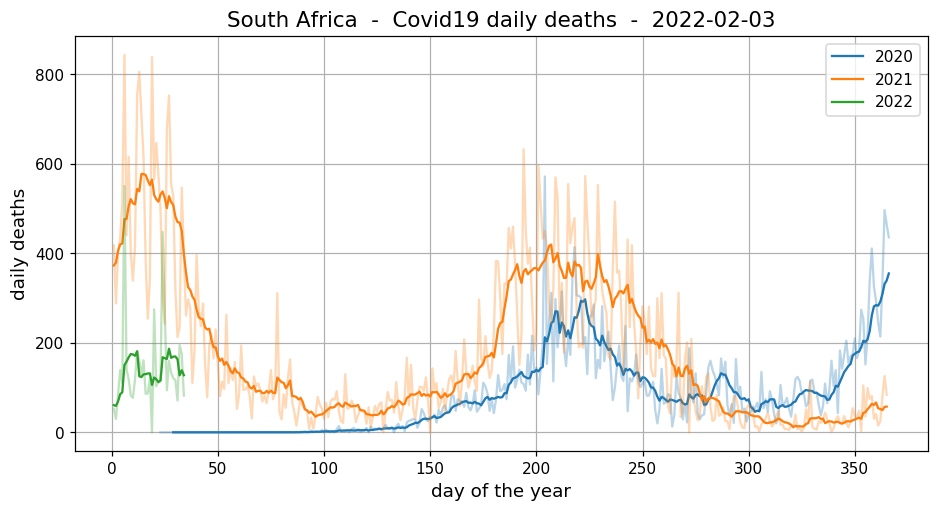

In [67]:
_ = create_YoY_plot(df, 
                    country="South Africa", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

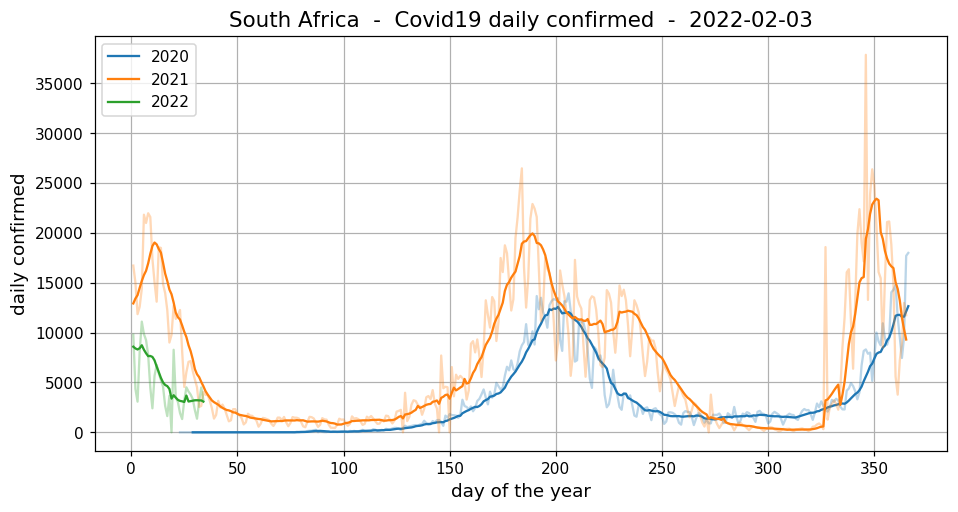

In [68]:
_ = create_YoY_plot(df, 
                    country="South Africa", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

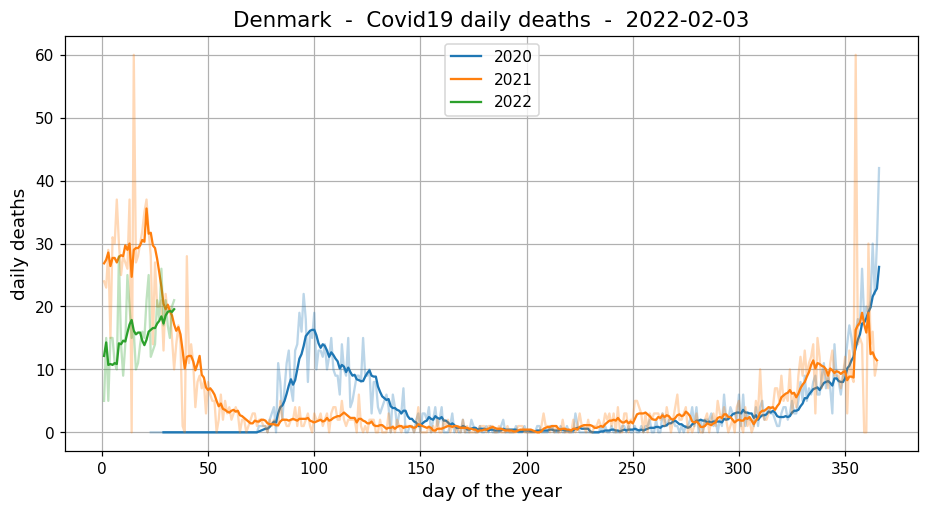

In [69]:
_ = create_YoY_plot(df, 
                    country="Denmark", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

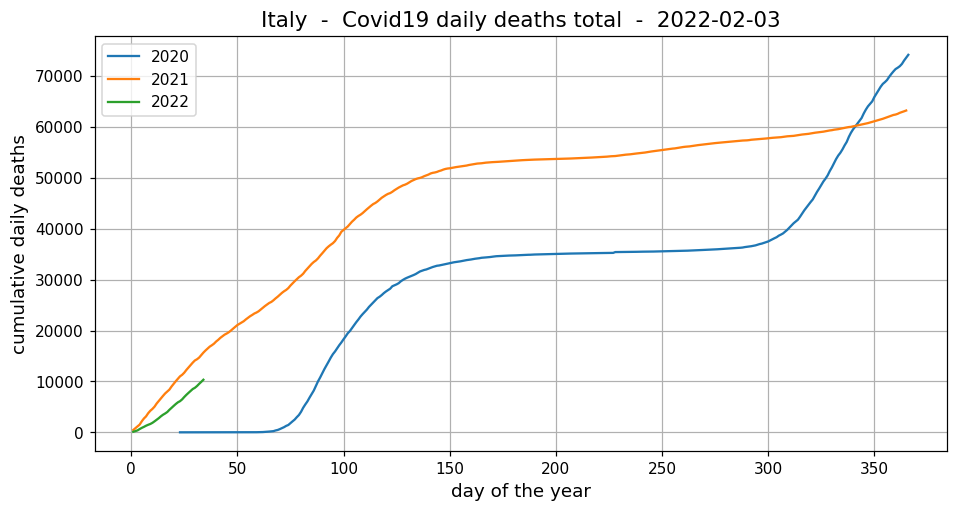

In [70]:
_ = create_YoY_plot(df, 
                    country="Italy", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=True,
                    std_cutoff=10)

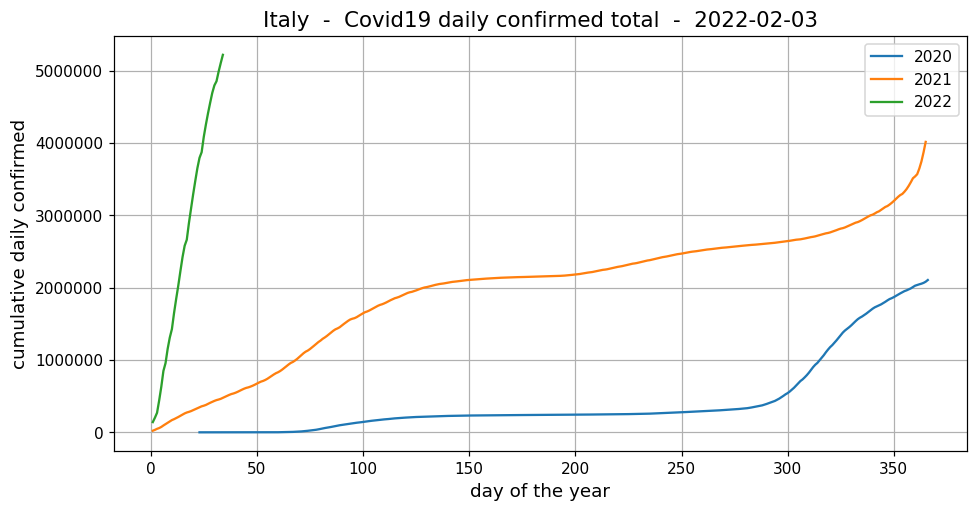

In [71]:
_ = create_YoY_plot(df, 
                    country="Italy", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=True,
                    std_cutoff=10)

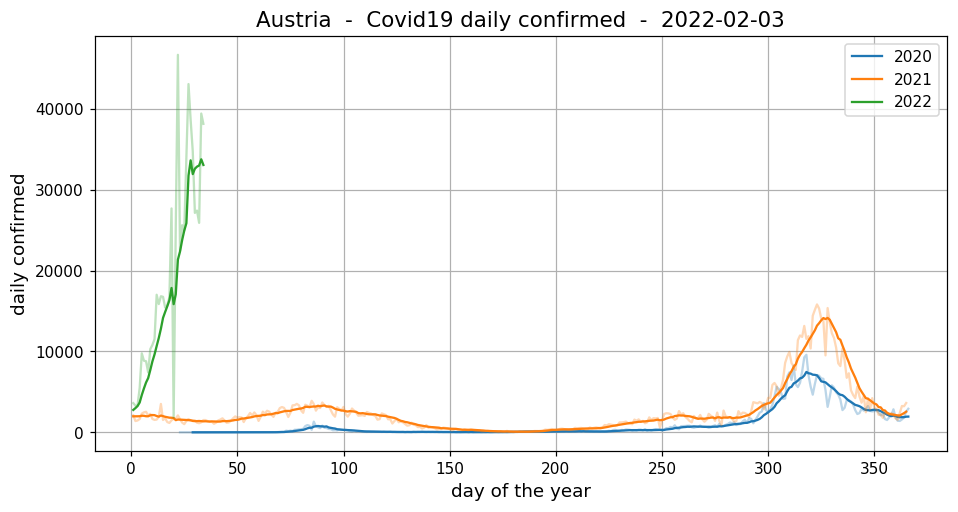

In [72]:
_ = create_YoY_plot(df, 
                    country="Austria", 
                    varname="daily_confirmed", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

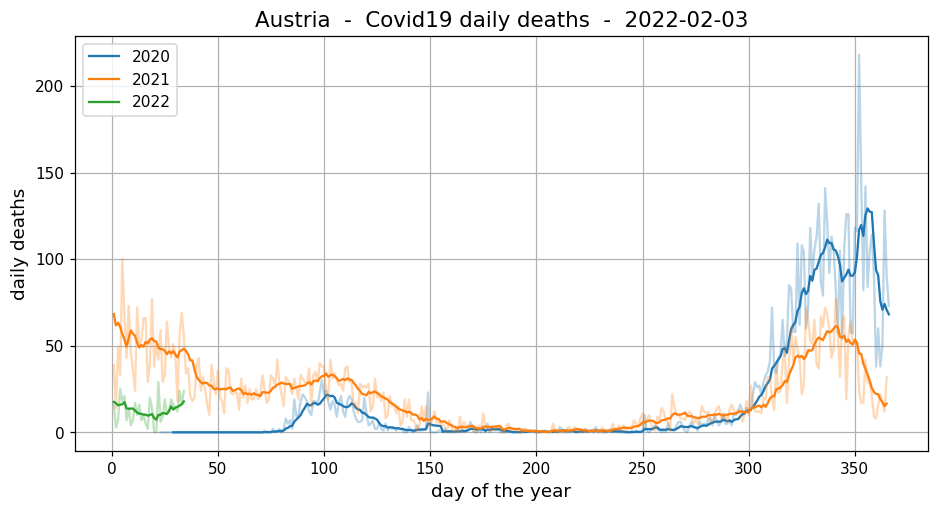

In [74]:
_ = create_YoY_plot(df, 
                    country="Austria", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

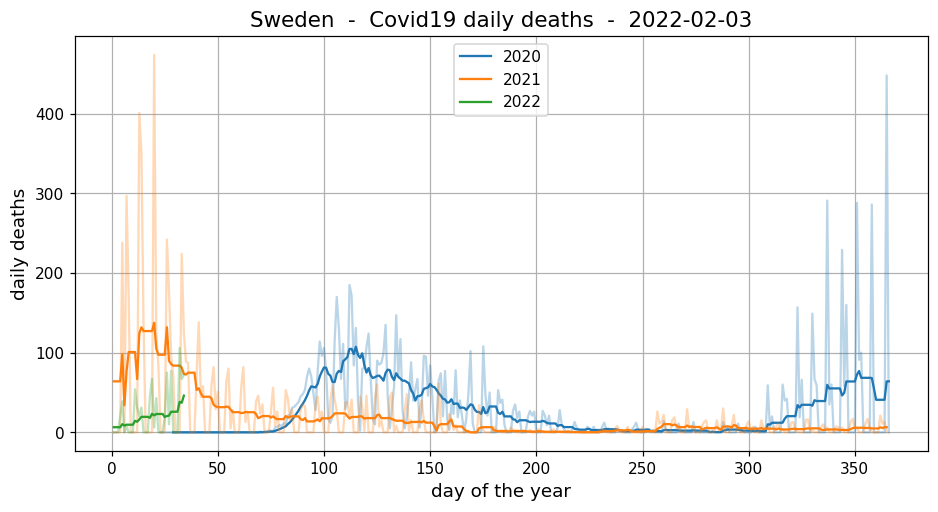

In [41]:
_ = create_YoY_plot(df, 
                    country="Sweden", 
                    varname="daily_deaths", 
                    per_100k=False,
                    cumulative=False,
                    std_cutoff=10)

In [68]:
df.columns

Index(['Country', 'State', 'Date', 'confirmed', 'deaths', 'pop2020', 'pop2021',
       'confirmed_1000', 'daily_confirmed', 'daily_confirmed_1000',
       'daily_confirmed_mean_7d_1000', 'confirmed_last_7d',
       'confirmed_last_7d_1000', 'deaths_1000', 'daily_deaths',
       'daily_deaths_1000', 'daily_deaths_mean_7d_1000', 'deaths_last_7d',
       'deaths_last_7d_1000', 'people_fully_vaccinated',
       'pop_fully_vaccinated', 'daily_icu_per_million',
       'daily_hospitalizations_per_million'],
      dtype='object')

In [66]:
def plot_per_million(df,
                     varname, 
                     country_list, 
                     logscale = False,
                     title: str = None,
                     xtitle: str = None,
                     ytitle: str = None,
                     start_date: str = None,
                     country_col_name = "Country",
                     figsize_x = 12,
                     figsize_y = 6,
                     suffix: str = "",
                     days_interval: int = 28
                    ):
    
    if start_date:
        df = df[df["Date"] >= start_date]
    dates =  df["Date"].unique()
    xlabels = [dates[i] for i in range(0,len(dates)) if i % days_interval == 0]
    ax, fig = plt.subplots(dpi=160, figsize=(figsize_x,figsize_y))
    
    last_date = np.max(df["Date"])
    print(f"Last date: {last_date}")
    
    for country in country_list:
        df_plot = df[(df[country_col_name]==country) & (df["State"]=="")]
        plt.plot(df_plot["Date"], df_plot[varname],label=country,linewidth=2)
        last_value = df_plot[df_plot["Date"]==last_date][varname]
        plt.annotate(country, xy=(last_date,last_value), xytext=(5,0), textcoords="offset points",
                     color=plt.gca().lines[-1].get_color(),fontsize=11)
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    _=plt.xticks(xlabels, 
               fontsize=12, 
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right")
    plt.grid()
    if title:
        plt.title(title,fontsize=16)

    if logscale:
        plt.yscale("log")
        
    plt.ylabel(ytitle,fontsize=14)
    plt.savefig(f"./plots/{varname}_per_thousand{suffix}.png",bbox_inches="tight")

    


Last date: 2022-02-05 00:00:00


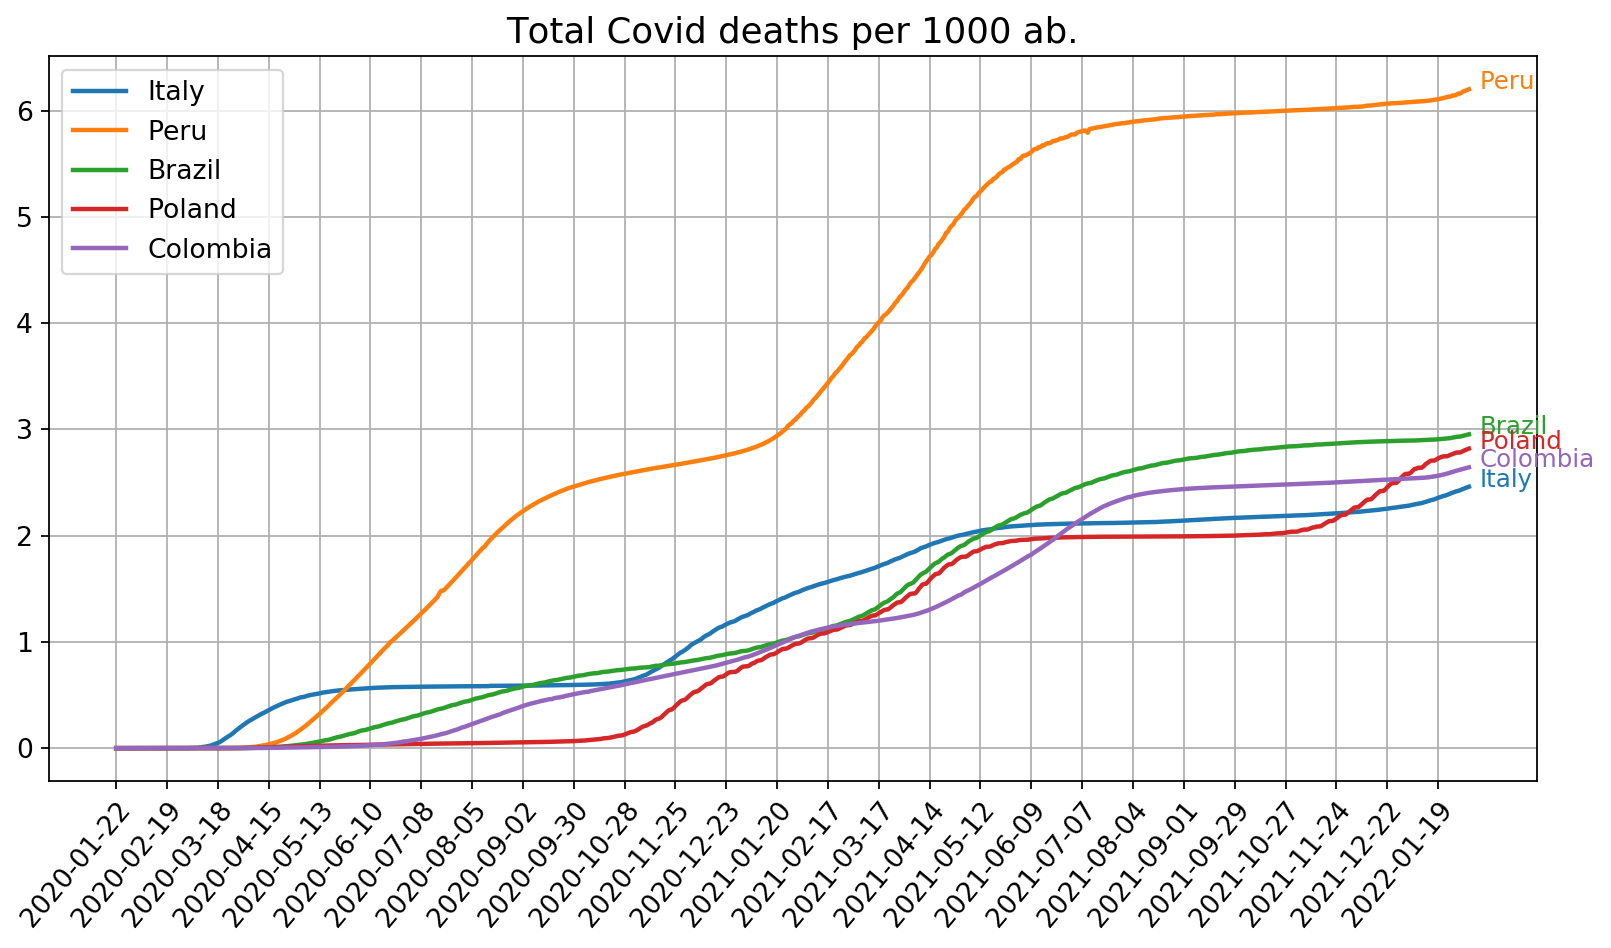

In [70]:
plot_per_million(df, 
                 varname="deaths_per_thousand", 
                 country_list=["Italy", "Peru", "Brazil","Poland","Colombia"],
                 logscale=False,
                 title="Total Covid deaths per 1000 ab."
                )

In [103]:
df_countries=df[df.Date=="2022-02-05"][["Date","Country","deaths_per_thousand"]].sort_values(by="deaths_per_thousand",ascending=False).head(50)

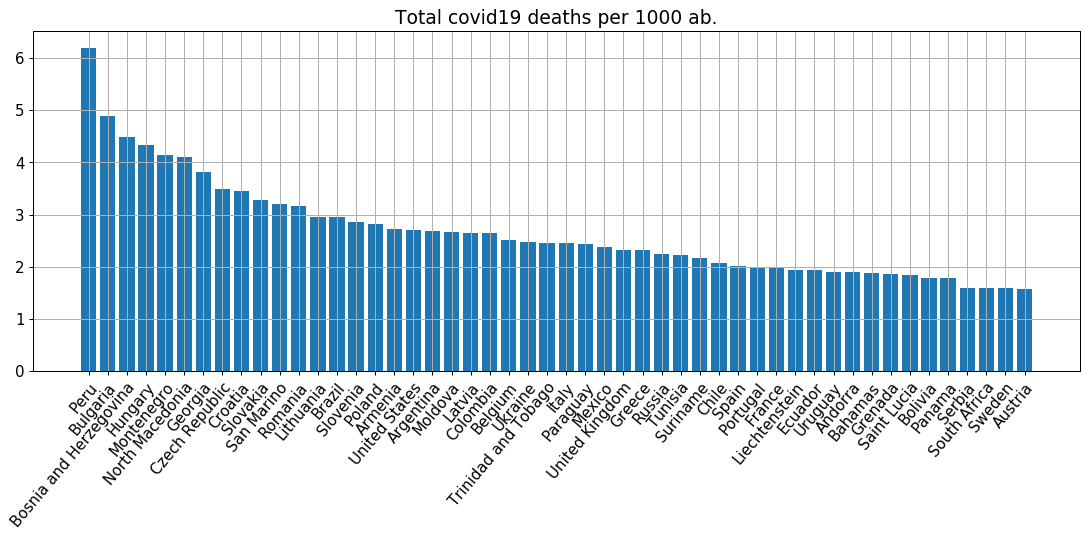

In [109]:
plt.figure(figsize=(15,5),dpi=90)
plt.bar(df_countries["Country"],df_countries["deaths_per_thousand"])
plt.grid()
plt.title("Total covid19 deaths per 1000 ab.", fontsize=15)
_ = plt.xticks(fontsize=12, rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right")
_ = plt.yticks(fontsize=12)

Last date: 2022-02-04 00:00:00


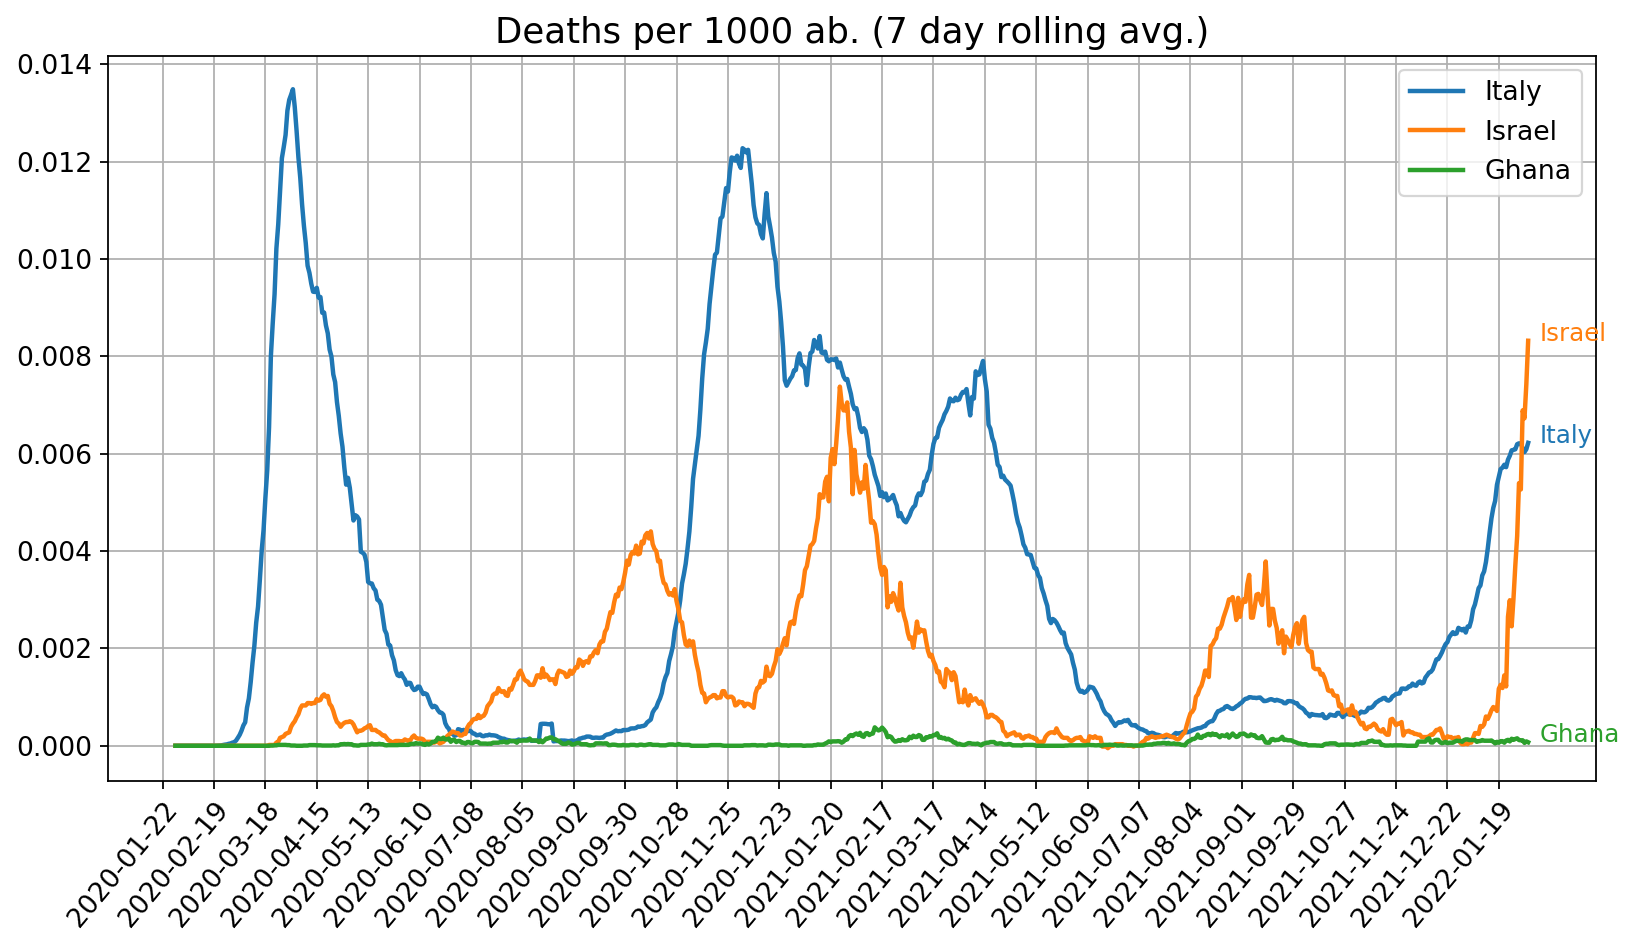

In [134]:
europe_countries = ["Italy", "Israel", "Ghana"]

plot_per_million(df, 
                 varname="daily_deaths_per_thousand_mean_7d", 
                 country_list=europe_countries,
                 title="Deaths per 1000 ab. (7 day rolling avg.)",
                 suffix="_ita_isr_ghana",
                 start_date="2020-01-01",
                 days_interval = 28,
                 logscale=False)

In [65]:
plot_per_million(df, 
                 varname="deaths_per_thousand", 
                 country_list=["Peru","Brasile","Polonia"],
                 suffix="total_covid_deaths",
                 start_date="2021-09-01",
                 title="Total Covid deaths per 1000 ab.",
                 logscale=False)

NameError: name 'plot_per_million' is not defined

Last date: 2021-12-26 00:00:00


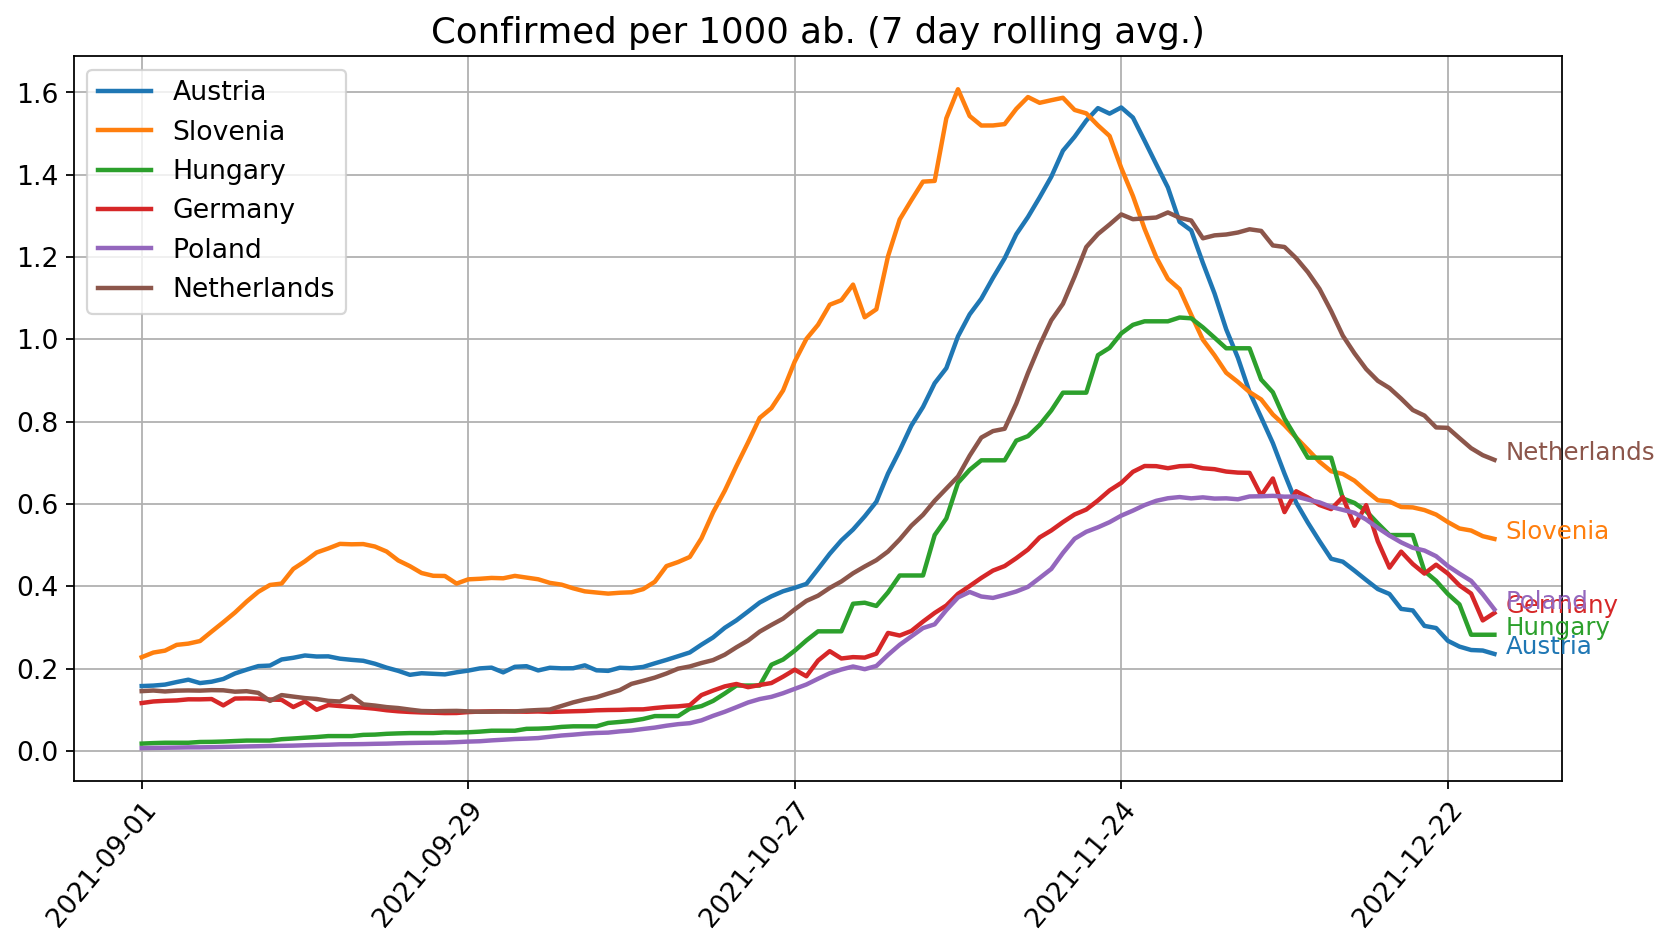

In [84]:
plot_per_million(df, 
                 varname="daily_confirmed_mean_7d_1000", 
                 country_list=["Austria", "Slovenia","Hungary", "Germany", "Poland","Netherlands"],
                 title="Confirmed per 1000 ab. (7 day rolling avg.)",
                 start_date="2021-09-01",
                 logscale=False)

In [77]:
import sys
sys.path.append("../")
from utils import createXYPlot

In [78]:
df.columns

Index(['Country', 'State', 'Date', 'confirmed', 'deaths', 'pop2020', 'pop2021',
       'confirmed_1000', 'daily_confirmed', 'daily_confirmed_1000',
       'daily_confirmed_mean_7d_1000', 'confirmed_last_7d',
       'confirmed_last_7d_1000', 'deaths_1000', 'daily_deaths',
       'daily_deaths_1000', 'daily_deaths_mean_7d_1000', 'deaths_last_7d',
       'deaths_last_7d_1000', 'people_fully_vaccinated',
       'pop_fully_vaccinated', 'daily_icu_per_million',
       'daily_hospitalizations_per_million'],
      dtype='object')

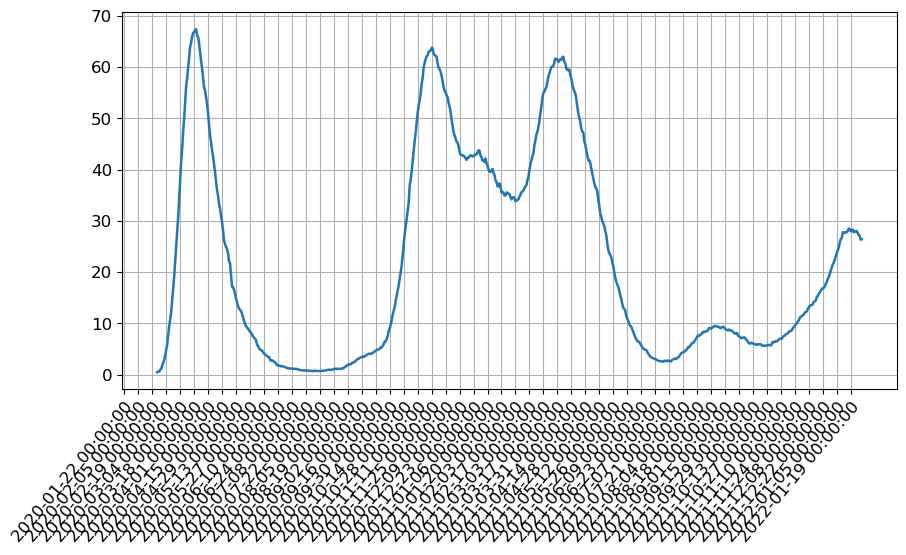

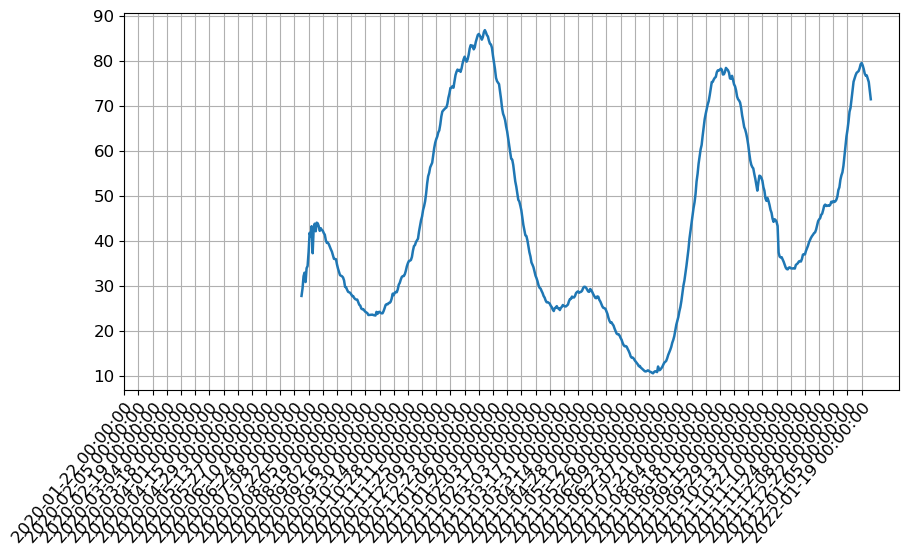

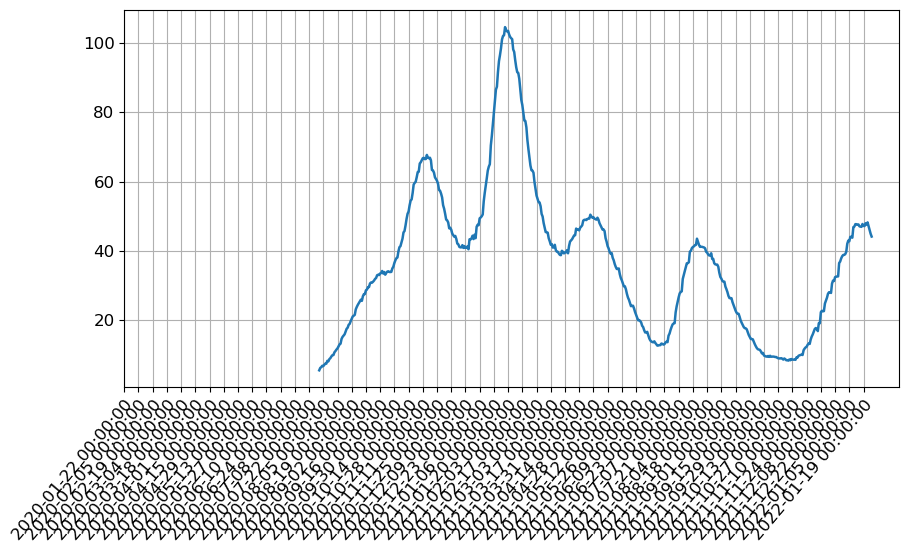

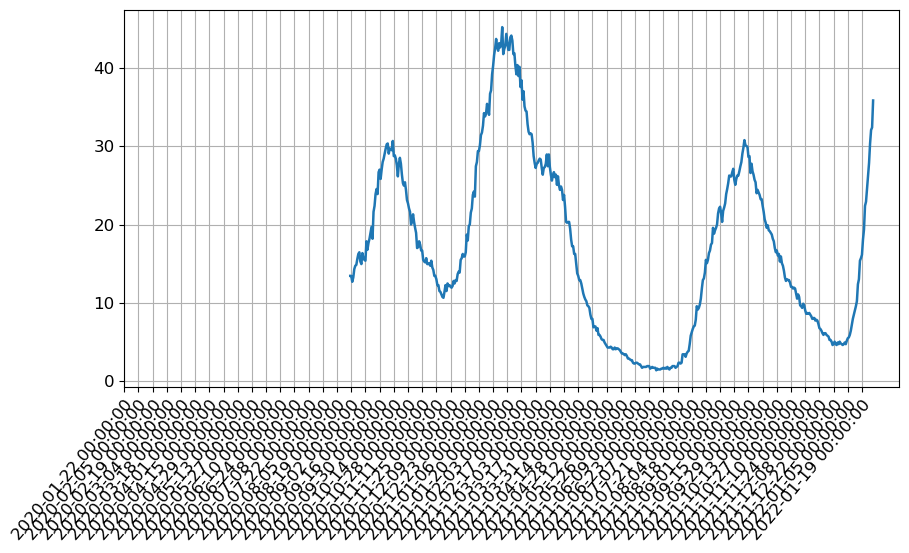

In [80]:
for c in ["Italy","United States","Spain","Israel"]:
    df_plt=df[df.Country==c]
    createXYPlot(df_plt,
                 x="Date",
                 y="daily_icu_per_million",
                 plots_folder=None,
                 days_interval=14,
                 linewidth=1.8
                )

In [143]:
s = np.sqrt(2.2**2/1258 + 2.5**2/326)

In [144]:
delta = 4.9-3.9

In [145]:
t = delta/s

In [146]:
t

6.591060568423812

In [147]:
import scipy
scipy.stats.norm.sf(abs(delta/s))*2

4.3669567182650854e-11

In [135]:
scipy.stats.norm.sf(x=1.645)

0.049984905539121376